# CAS MAIN 2020 - Modul Deep Learning
## Comparison of deep learning algorithms for time series forecasting
### Daniel Brühlmeier & Marc Lancaster, 14-Apr-2020, ZHAW CAS MAIN

***
### Contents
0. import modules
1. Retrieve price data
2. Enrich, analyze and plot price data
3. Split price data into input (X) and target (Y)
4. SECTION A: 1D CNN
5. SECTION B: fcNN
6. SECTION C: LSTM
7. SECTION D: 2D CNN

***

***
## 0. import modules

In [1]:
# import modules
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd 
#import yfinance as yf

from numpy import array
#from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from statsmodels.graphics.tsaplots import plot_acf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution1D, Convolution2D
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten , Activation, Lambda, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

from sklearn.metrics import accuracy_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# get the data
 
!cd /content/
!rm -R *
!wget 'https://github.com/bruhldan/dl_timeseries/blob/master/content/DL_TS_2020-04-06.zip?raw=true' -O data.zip
!unzip data.zip
!ls -al

--2020-04-09 06:10:46--  https://github.com/bruhldan/dl_timeseries/blob/master/content/DL_TS_2020-04-06.zip?raw=true
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/bruhldan/dl_timeseries/raw/master/content/DL_TS_2020-04-06.zip [following]
--2020-04-09 06:10:46--  https://github.com/bruhldan/dl_timeseries/raw/master/content/DL_TS_2020-04-06.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bruhldan/dl_timeseries/master/content/DL_TS_2020-04-06.zip [following]
--2020-04-09 06:10:46--  https://raw.githubusercontent.com/bruhldan/dl_timeseries/master/content/DL_TS_2020-04-06.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

In [3]:
# set pandas options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 2000)
pd.set_option('precision', 8)

# increase jupyter cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

***
## 1. Retrieve price data

In [4]:
### data has been retrieved using yfinance and direct download from 
### https://finance.yahoo.com for missing data
### data for period 1970-01-01 to 2020-03-31 is stored in the csv file
dfprice = pd.read_csv('/content/dfprice_dji_1970_20200331.csv')
dfprice.set_index('Date', inplace=True)
dfprice.index = pd.to_datetime(dfprice.index)
dfprice.sort_index(inplace=True)
dfprice.shape

(12670, 6)

In [5]:
dfprice.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1970-01-02,809.20001221,809.20001221,809.20001221,809.20001221,809.20001221,0
1970-01-05,811.30999756,811.30999756,811.30999756,811.30999756,811.30999756,0
1970-01-06,803.65997314,803.65997314,803.65997314,803.65997314,803.65997314,0
1970-01-07,801.80999756,801.80999756,801.80999756,801.80999756,801.80999756,0
1970-01-08,802.07000732,802.07000732,802.07000732,802.07000732,802.07000732,0


In [6]:
dfprice.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-25,21050.34,22019.93,20538.34,21200.55,21200.55,796320000
2020-03-26,21468.38,22595.06,21427.10,22552.17,22552.17,705180000
2020-03-27,21898.47,22327.57,21469.27,21636.78,21636.78,588830000
2020-03-30,21678.22,22378.09,21522.08,22327.48,22327.48,545540000
2020-03-31,22208.42,22480.37,21852.08,21917.16,21917.16,571210000


***
## 2. Enrich, analyze and plot price data

In [0]:
# keep only the 'Close' price column 
df = dfprice.loc[:, ['Close']].copy()
df.columns = map(str.lower, df.columns)
df['close'] = df['close'].astype('float64')
df['return'] = df['close'].diff(1)
df['log_return'] = np.log(df['close']).diff(1)

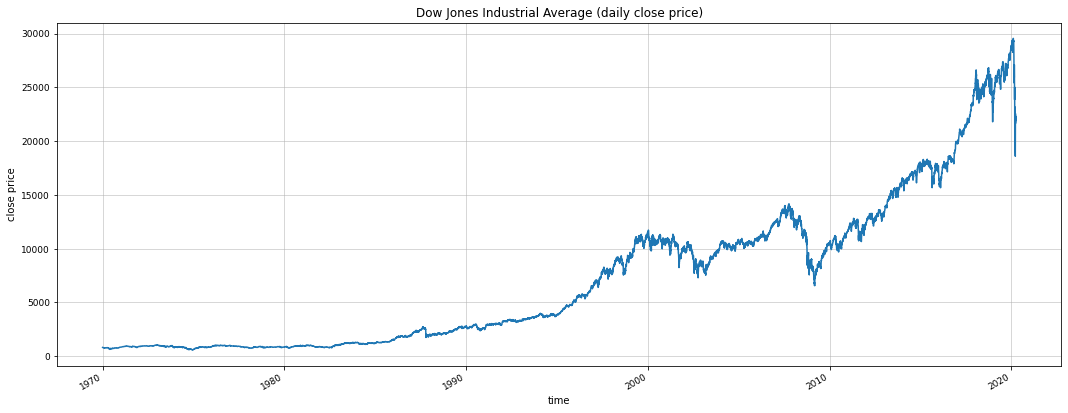

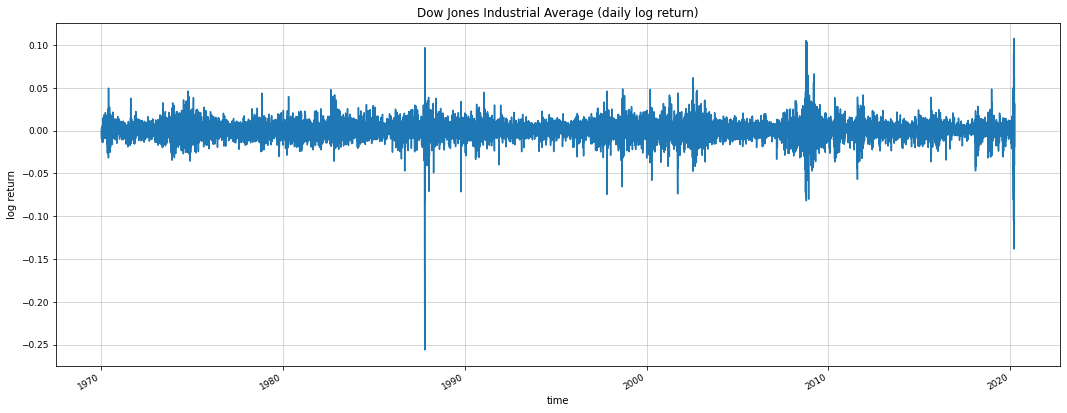

In [8]:
# chart of daily Close Price and daily log return
plt.figure(figsize=(18,7))
ax = df['close'].plot(label = 'close')
ax.grid(linewidth=0.5)
ax.set(xlabel="time", ylabel="close price", title = 'Dow Jones Industrial Average (daily close price)')
ax.xaxis.set_tick_params(labelsize=9)
ax.yaxis.set_tick_params(labelsize=9)
#plt.tight_layout()
plt.show()

plt.figure(figsize=(18,7))
ax = df['log_return'].plot(label = 'log_return')
ax.grid(linewidth=0.5)
ax.set(xlabel="time", ylabel="log return", title = 'Dow Jones Industrial Average (daily log return)')
ax.xaxis.set_tick_params(labelsize=9)
ax.yaxis.set_tick_params(labelsize=9)
plt.show()

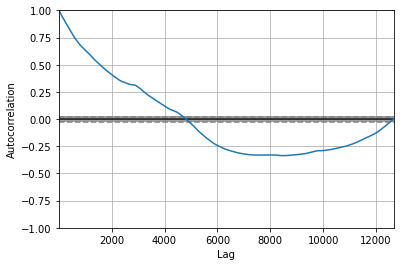

In [9]:
# plot autocorrelation of close (--> makes no sense, therefore plot acf of log_return next)
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['close'])
plt.show()

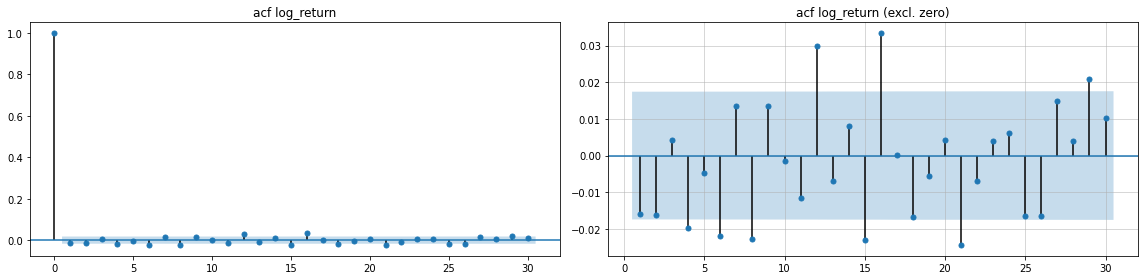

In [10]:
# plot acf of log_return to decide on timesteps
# timestep for set1: 8 days
# timestep for set2: 16 days
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
plot_acf(df['log_return'][1:], lags=30, use_vlines=True, zero=True, ax=ax[0], title='acf log_return')
plot_acf(df['log_return'][1:], lags=30, use_vlines=True, zero=False, ax=ax[1], title='acf log_return (excl. zero)')
plt.grid(linewidth=0.5)
fig.tight_layout()
plt.show()

In [11]:
# Check distribution between up and down days
sel_up = df['return'] > 0
sel_down = df['return'] < 0
sel_unch = df['return'] == 0
up = df.loc[sel_up, 'return']
down = df.loc[sel_down, 'return']
unch = df.loc[sel_unch, 'return']
print('total number of days:', len(df))
print('up days:', len(up), '(', round(len(up)/len(df), 2), ')')
print('down days:', len(down), '(', round(len(down)/len(df), 2), ')')
print('unchanged days:', len(unch), '(', round(len(unch)/len(df), 2), ')')

total number of days: 12670
up days: 6597 ( 0.52 )
down days: 6032 ( 0.48 )
unchanged days: 40 ( 0.0 )


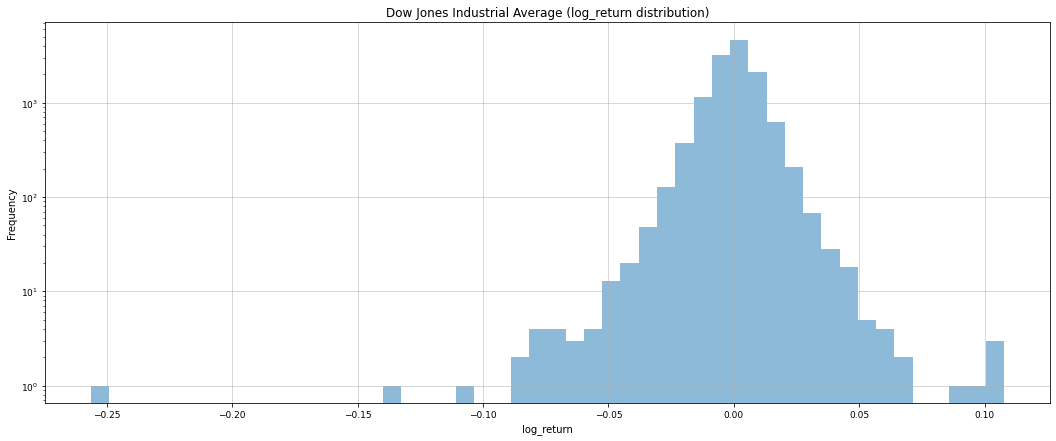

In [12]:
# plot distribution of log_return
plt.figure(figsize=(18,7))
ax = df['log_return'].plot.hist(bins=50, alpha=0.5)
ax.grid(linewidth=0.5)
ax.set(xlabel="log_return",  title = 'Dow Jones Industrial Average (log_return distribution)')
ax.xaxis.set_tick_params(labelsize=9)
ax.yaxis.set_tick_params(labelsize=9)
ax.set_yscale('log')
#plt.tight_layout()
plt.show()

In [13]:
df['log_return'].describe()

count    12669.00000000
mean         0.00026040
std          0.01081840
min         -0.25631956
25%         -0.00473417
50%          0.00040693
75%          0.00553504
max          0.10764325
Name: log_return, dtype: float64

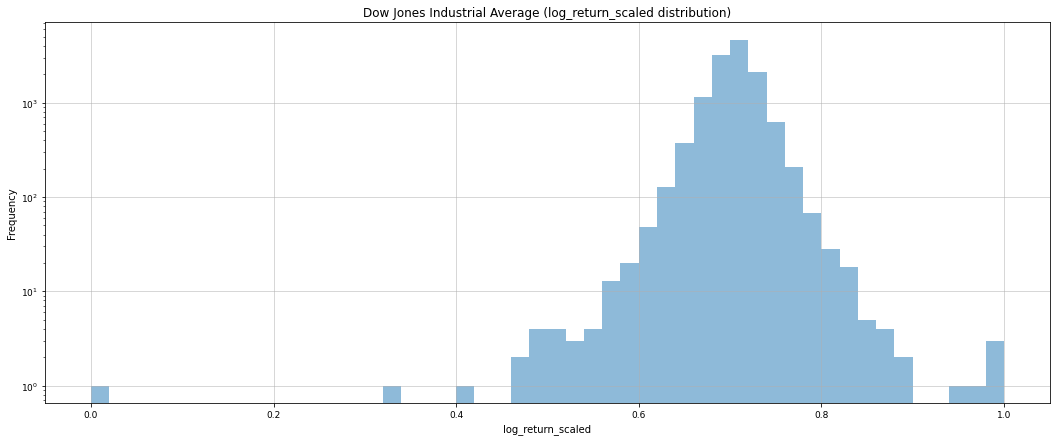

In [14]:
# Apply MinMaxScaler to log_return to get values between 0 and 1
sc = MinMaxScaler(feature_range=(0,1))
df['log_return_scaled'] = sc.fit_transform(df[['log_return']])

plt.figure(figsize=(18,7))
ax = df['log_return_scaled'].plot.hist(bins=50, alpha=0.5)
ax.grid(linewidth=0.5)
ax.set(xlabel="log_return_scaled", title = 'Dow Jones Industrial Average (log_return_scaled distribution)')
ax.xaxis.set_tick_params(labelsize=9)
ax.yaxis.set_tick_params(labelsize=9)
ax.set_yscale('log')
#plt.tight_layout()
plt.show()

In [15]:
df['log_return_scaled'].describe()

count    12669.00000000
mean         0.70496202
std          0.02972391
min          0.00000000
25%          0.69123927
50%          0.70536463
75%          0.71945428
max          1.00000000
Name: log_return_scaled, dtype: float64

***
## 3. Split price data into input (X) and target (Y)

In [0]:
# convert dataframe to array for log_return
# remove first day since it's NA
raw_seq_log_return = df['log_return'].to_numpy()
raw_seq_log_return = raw_seq_log_return[1:]

In [0]:
# define function to split a univariate sequence into samples
def split_sequence(sequence, n_steps, sign=False):
    
    X, Y = list(), list()
    
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        
        seq_x = sequence[i:end_ix]
        
        if sign:
            seq_y = np.sign(sequence[end_ix])
            if seq_y < 0:
                seq_y = 0
        else:
            seq_y = sequence[end_ix]
        
        X.append(seq_x)
        Y.append(seq_y)
        
    return array(X), array(Y)

### 3.a) Split data for set1 -> timesteps = 8

In [0]:
# choose number of days for input data set (e.g. 8 previous days will used to predict the next day's value)
n_steps_set1 = 8
# set number of features (in our case 1)
n_features = 1

In [0]:
# split data into input (log_return) and target (sign of log_return = up or down = 1 or 0)
X_logret_set1, Y_sign_set1 = split_sequence(raw_seq_log_return, n_steps_set1, sign=True)
# summarize the data
#for i in range(len(X_logret_set1)):
#    print(X_logret_set1[i], Y_sign_set1[i])

In [20]:
# check shape of the data, final shape needs to have 3 dimensions
print(X_logret_set1.shape)
print(Y_sign_set1.shape)

(12661, 8)
(12661,)


In [21]:
# add scaled X using MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X_logret_set1_scaled = sc.fit_transform(X_logret_set1)
# and check the shape again and some values
print(X_logret_set1_scaled.shape)
print(X_logret_set1_scaled[0:2])
print(X_logret_set1[0:2])

(12661, 8)
[[0.71644023 0.6830203  0.7028579  0.70513739 0.6906477  0.67799269
  0.69550889 0.70128116]
 [0.6830203  0.7028579  0.71013183 0.6906477  0.67799269 0.69550889
  0.70128116 0.69683687]]
[[ 0.0026041  -0.00947396 -0.00230459  0.00032423 -0.00494948 -0.00955543
  -0.00318019 -0.0010793 ]
 [-0.00947396 -0.00230459  0.00032423 -0.00494948 -0.00955543 -0.00318019
  -0.0010793  -0.00269685]]


In [22]:
# reshape to fit the final form for input to the NN's
# X from [samples, timesteps] into [samples, timesteps, features]
X_logret_set1 = X_logret_set1.reshape((X_logret_set1.shape[0], X_logret_set1.shape[1], n_features))
X_logret_set1_scaled = X_logret_set1_scaled.reshape((X_logret_set1_scaled.shape[0], X_logret_set1_scaled.shape[1], n_features))
# Y from [samples] into [samples, timesteps, features]
Y_sign_set1 = Y_sign_set1.reshape((len(Y_sign_set1),1))
Y_sign_flat_set1 = Y_sign_set1
Y_sign_set1 = Y_sign_set1.reshape((Y_sign_set1.shape[0], Y_sign_set1.shape[1], n_features))
print(X_logret_set1.shape)
print(X_logret_set1_scaled.shape)
print(Y_sign_set1.shape)
print(Y_sign_flat_set1.shape)
# Y_sign_flat_set1 is used later on to calculate model accuracy manually

(12661, 8, 1)
(12661, 8, 1)
(12661, 1, 1)
(12661, 1)


### 3.b) Split data for set2 -> timesteps = 16

In [0]:
# choose number of days for input data set (e.g. 8 previous days will used to predict the next day's value)
n_steps_set2 = 16
# set number of features (in our case 1)
n_features = 1

In [0]:
# split data into input (log_return) and target (sign of log_return = up or down = 1 or 0)
X_logret_set2, Y_sign_set2 = split_sequence(raw_seq_log_return, n_steps_set2, sign=True)
# summarize the data
#for i in range(len(X_logret_set2)):
#    print(X_logret_set2[i], Y_sign_set2[i])

In [25]:
# check shape of the data, final shape needs to have 3 dimensions
print(X_logret_set2.shape)
print(Y_sign_set2.shape)

(12653, 16)
(12653,)


In [26]:
# add scaled X using MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X_logret_set2_scaled = sc.fit_transform(X_logret_set2)
# and check the shape again and some values
print(X_logret_set2_scaled.shape)
print(X_logret_set2_scaled[0:2])
print(X_logret_set2[0:2])

(12653, 16)
[[0.71644023 0.6830203  0.7028579  0.71013183 0.69553951 0.68279487
  0.70043513 0.70624829 0.70177252 0.70062114 0.6860502  0.710541
  0.71981492 0.71766553 0.66708769 0.68055014]
 [0.6830203  0.7028579  0.71013183 0.69553951 0.68279487 0.70043513
  0.70624829 0.70177252 0.70062114 0.6860502  0.71557371 0.71981492
  0.71766553 0.66708769 0.68055014 0.68671667]]
[[ 0.0026041  -0.00947396 -0.00230459  0.00032423 -0.00494948 -0.00955543
  -0.00318019 -0.0010793  -0.00269685 -0.00311297 -0.00837895  0.00229094
   0.0056663   0.00488401 -0.01352445 -0.00862462]
 [-0.00947396 -0.00230459  0.00032423 -0.00494948 -0.00955543 -0.00318019
  -0.0010793  -0.00269685 -0.00311297 -0.00837895  0.00229094  0.0056663
   0.00488401 -0.01352445 -0.00862462 -0.00638023]]


In [27]:
# reshape to fit the final form for input to the NN's
# X from [samples, timesteps] into [samples, timesteps, features]
X_logret_set2 = X_logret_set2.reshape((X_logret_set2.shape[0], X_logret_set2.shape[1], n_features))
X_logret_set2_scaled = X_logret_set2_scaled.reshape((X_logret_set2_scaled.shape[0], X_logret_set2_scaled.shape[1], n_features))
# Y from [samples] into [samples, timesteps, features]
Y_sign_set2 = Y_sign_set2.reshape((len(Y_sign_set2),1))
Y_sign_set2 = Y_sign_set2.reshape((Y_sign_set2.shape[0], Y_sign_set2.shape[1], n_features))
print(X_logret_set2.shape)
print(X_logret_set2_scaled.shape)
print(Y_sign_set2.shape)

(12653, 16, 1)
(12653, 16, 1)
(12653, 1, 1)
(12653, 1)


***
### 3.c) Split data just into train (70%) and validation (30%)

In [28]:
# total length of dataset
len(raw_seq_log_return)

12669

In [29]:
# split 70% train, 30% val
# bei daten bis und mit 2020-03-31 heisst das
# train: 0-8867, val: 8868-12669
splitter = int(len(raw_seq_log_return) * 0.7)
splitter

8868


### 3.d) Spit data into train (70%), validation (10%) and test (20%)

In [30]:
train_id = int(len(raw_seq_log_return) * 0.7)
val_id = int(len(raw_seq_log_return) * 0.8)
train_id, val_id

(8868, 10135)

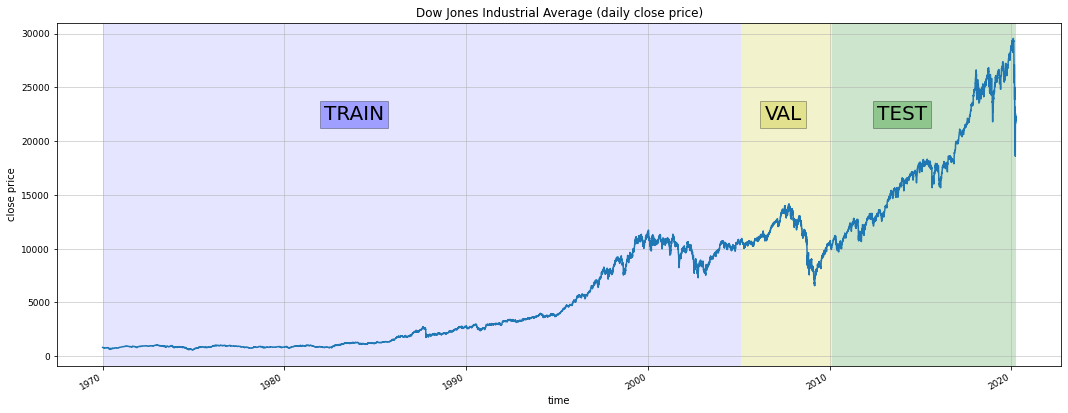

In [31]:
# chart of daily Close Price and daily log return
plt.figure(figsize=(18,7))
ax = df['close'].plot(label = 'close')
ax.grid(linewidth=0.5)
ax.set(xlabel="time", ylabel="close price", title = 'Dow Jones Industrial Average (daily close price)')
ax.xaxis.set_tick_params(labelsize=9)
ax.yaxis.set_tick_params(labelsize=9)
plt.axvspan(df.index[0], df.index[train_id], color='b', alpha=0.1, lw=0)
plt.axvspan(df.index[train_id], df.index[val_id], color='y', alpha=0.2, lw=0)
plt.axvspan(df.index[val_id], df.index[-1], color='g', alpha=0.2, lw=0)
plt.text(df.index[3500], 22500, 'TRAIN', horizontalalignment='center', verticalalignment='center', fontsize=20, bbox=dict(facecolor='b', alpha=0.3))
plt.text(df.index[9450], 22500, 'VAL', horizontalalignment='center', verticalalignment='center', fontsize=20, bbox=dict(facecolor='y', alpha=0.3))
plt.text(df.index[11100], 22500, 'TEST', horizontalalignment='center', verticalalignment='center', fontsize=20, bbox=dict(facecolor='g', alpha=0.3))
#plt.tight_layout()
plt.show()

***
# 4. SECTION A: 1D CNN

***
### A1) 1D CNN - non-scaled - without dilation - 8 timesteps
- input: log_return (non-scaled) 
- target: sign (up/down, 1 or 0) 
- dilation rate: no dilation
- timesteps: 8

In [32]:
model_a1 = Sequential()
ks = 3
model_a1.add(Convolution1D(filters=8, activation='relu', kernel_size=ks, padding='causal', input_shape=(n_steps_set1,1)))
model_a1.add(Convolution1D(filters=8, activation='relu', kernel_size=ks, padding='causal'))
model_a1.add(Convolution1D(filters=16, activation='relu', kernel_size=ks, padding='causal'))
model_a1.add(Convolution1D(filters=16, activation='relu', kernel_size=ks, padding='causal'))
model_a1.add(Flatten())
model_a1.add(Dense(1, activation='sigmoid'))
model_a1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_a1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 8, 8)              32        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 8)              200       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 16)             400       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 16)             784       
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,545
Trainable params: 1,545
Non-trainable params: 0
______________________________________________________

In [33]:
# define the input & target dataset
# check that we're using the right input set
X = X_logret_set1
Y = Y_sign_set1
n_steps_set1, X[0:1], Y[0:1]

(8, array([[[ 0.0026041 ],
         [-0.00947396],
         [-0.00230459],
         [ 0.00032423],
         [-0.00494948],
         [-0.00955543],
         [-0.00318019],
         [-0.0010793 ]]]), array([[[0.]]]))

In [34]:
# split data into train, val and test
X_train = X[0:train_id]
Y_train = Y[0:train_id]
X_val   = X[train_id:val_id]
Y_val   = Y[train_id:val_id]
X_test  = X[val_id:]
Y_test  = Y[val_id:]
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(8868, 8, 1) (8868, 1, 1)
(1267, 8, 1) (1267, 1, 1)
(2526, 8, 1) (2526, 1, 1)


In [35]:
history_a1 = model_a1.fit(X_train, Y_train,
                          epochs=100,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/100
70/70 [==============================] - 1s 9ms/step - loss: 0.6930 - accuracy: 0.5091 - val_loss: 0.6920 - val_accuracy: 0.5328
Epoch 2/100
70/70 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5133 - val_loss: 0.6919 - val_accuracy: 0.5328
Epoch 3/100
70/70 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5133 - val_loss: 0.6918 - val_accuracy: 0.5328
Epoch 4/100
70/70 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5133 - val_loss: 0.6919 - val_accuracy: 0.5328
Epoch 5/100
70/70 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5133 - val_loss: 0.6917 - val_accuracy: 0.5328
Epoch 6/100
70/70 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5133 - val_loss: 0.6917 - val_accuracy: 0.5328
Epoch 7/100
70/70 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5133 - val_loss: 0.6916 - val_accuracy: 0.5328
Epoch 8/100
7

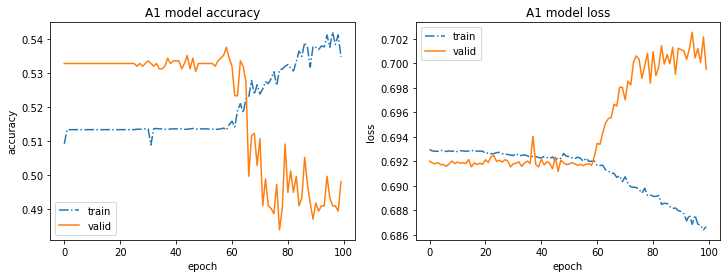

In [36]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_a1.history['accuracy'],linestyle='-.')
plt.plot(history_a1.history['val_accuracy'])
plt.title('A1 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower left')

plt.subplot(1,2,(2))
plt.plot(history_a1.history['loss'],linestyle='-.')
plt.plot(history_a1.history['val_loss'])
plt.title('A1 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [37]:
# evaluate the model
_, train_acc_a1 = model_a1.evaluate(X_train, Y_train, verbose=0)
_, val_acc_a1   = model_a1.evaluate(X_val, Y_val, verbose=0)
_, test_acc_a1  = model_a1.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_a1, val_acc_a1, test_acc_a1))

Train: 0.5441, Val: 0.4980, Test: 0.4952


In [0]:
## validating differently if these numbers are correct

In [39]:
# --- manually calculate accuracy
train_preds = np.where(model_a1.predict(X_train) >= 0.5, 1, 0)
test_preds = np.where(model_a1.predict(X_test) >= 0.5, 1, 0)
train_preds.shape, test_preds.shape

((8868, 1), (2526, 1))

In [40]:
# print train accuracy score
accuracy_score(Y_sign_flat_set1[:train_id], train_preds)

0.5440911141181777

In [41]:
# print test accuracy score et voila, results are the same
accuracy_score(Y_sign_flat_set1[val_id:], test_preds)

0.49524940617577196

In [42]:
res_a1 = pd.DataFrame(
          {'ID': 'A1',
           'Type': '1D CNN',
           'Timesteps': n_steps_set1,
           'Train Acc': train_acc_a1,
           'Val Acc': val_acc_a1,
           'Test Acc': test_acc_a1}, index=['A1: 1D CNN - non-scaled - without dilation - 8 timesteps'])
res_a1

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942


***
### A2) 1D CNN - scaled - without dilation - 8 timesteps
- input: log_return_scaled
- target: sign (up/down, 1 or 0) 
- dilation rate: no dilation
- timesteps: 8

In [43]:
model_a2 = Sequential()
ks = 3
model_a2.add(Convolution1D(filters=8, activation='relu', kernel_size=ks, padding='causal', input_shape=(n_steps_set1,1)))
model_a2.add(Convolution1D(filters=8, activation='relu', kernel_size=ks, padding='causal'))
model_a2.add(Convolution1D(filters=16, activation='relu', kernel_size=ks, padding='causal'))
model_a2.add(Convolution1D(filters=16, activation='relu', kernel_size=ks, padding='causal'))
model_a2.add(Flatten())
model_a2.add(Dense(1, activation='sigmoid'))
model_a2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_a2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 8, 8)              32        
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 8, 8)              200       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 8, 16)             400       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 8, 16)             784       
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,545
Trainable params: 1,545
Non-trainable params: 0
____________________________________________________

In [44]:
# define the input & target dataset
# check that we're using the right input set
X = X_logret_set1_scaled
Y = Y_sign_set1
n_steps_set1, X[0:1], Y[0:1]

(8, array([[[0.71644023],
         [0.6830203 ],
         [0.7028579 ],
         [0.70513739],
         [0.6906477 ],
         [0.67799269],
         [0.69550889],
         [0.70128116]]]), array([[[0.]]]))

In [45]:
# split data into train, val and test
X_train = X[0:train_id]
Y_train = Y[0:train_id]
X_val   = X[train_id:val_id]
Y_val   = Y[train_id:val_id]
X_test  = X[val_id:]
Y_test  = Y[val_id:]
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(8868, 8, 1) (8868, 1, 1)
(1267, 8, 1) (1267, 1, 1)
(2526, 8, 1) (2526, 1, 1)


In [46]:
history_a2 = model_a2.fit(X_train, Y_train,
                          epochs=200,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/200
70/70 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5134 - val_loss: 0.6917 - val_accuracy: 0.5328
Epoch 2/200
70/70 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5133 - val_loss: 0.6919 - val_accuracy: 0.5328
Epoch 3/200
70/70 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5133 - val_loss: 0.6918 - val_accuracy: 0.5328
Epoch 4/200
70/70 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5133 - val_loss: 0.6919 - val_accuracy: 0.5328
Epoch 5/200
70/70 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5133 - val_loss: 0.6919 - val_accuracy: 0.5328
Epoch 6/200
70/70 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5133 - val_loss: 0.6918 - val_accuracy: 0.5328
Epoch 7/200
70/70 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5133 - val_loss: 0.6918 - val_accuracy: 0.5328
Epoch 8/200
7

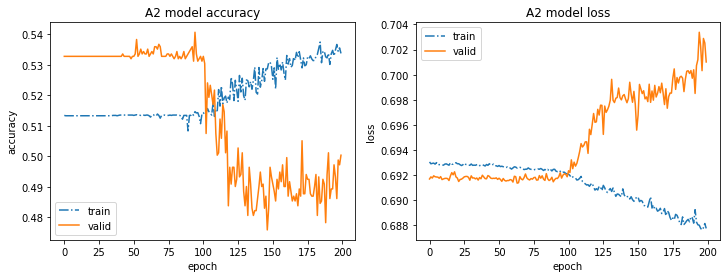

In [47]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_a2.history['accuracy'],linestyle='-.')
plt.plot(history_a2.history['val_accuracy'])
plt.title('A2 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower left')

plt.subplot(1,2,(2))
plt.plot(history_a2.history['loss'],linestyle='-.')
plt.plot(history_a2.history['val_loss'])
plt.title('A2 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [48]:
# evaluate the model
# !!! could show a high test accuracy, but actually the model doesn't converge, aso mummer glaubs striichä 
_, train_acc_a2 = model_a2.evaluate(X_train, Y_train, verbose=0)
_, val_acc_a2   = model_a2.evaluate(X_val, Y_val, verbose=0)
_, test_acc_a2  = model_a2.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_a2, val_acc_a2, test_acc_a2))

Train: 0.5385, Val: 0.5004, Test: 0.5055


In [49]:
res_a2 = pd.DataFrame(
          {'ID': 'A2',
           'Type': '1D CNN',
           'Timesteps': n_steps_set1,
           'Train Acc': train_acc_a2,
           'Val Acc': val_acc_a2,
           'Test Acc': test_acc_a2}, index=['A2: 1D CNN - scaled - without dilation - 8 timesteps'])

pd.concat([res_a1,res_a2])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234


***
### A3) 1D CNN - scaled - without dilation - 8 timesteps - tuned
- input: log_return_scaled
- target: sign (up/down, 1 or 0) 
- dilation rate: no dilation
- timesteps: 8

In [50]:
model_a3 = Sequential()
ks = 3
model_a3.add(BatchNormalization(input_shape=(n_steps_set1,1)))
model_a3.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model_a3.add(BatchNormalization())
model_a3.add(Activation('relu'))
#---
model_a3.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model_a3.add(BatchNormalization())
model_a3.add(Activation('relu'))
model_a3.add(MaxPooling1D((2)))
#---
model_a3.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model_a3.add(BatchNormalization())
model_a3.add(Activation('relu'))
#---
model_a3.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model_a3.add(BatchNormalization())
model_a3.add(Activation('relu'))
model_a3.add(MaxPooling1D((2)))
#---
model_a3.add(Flatten())
model_a3.add(Dropout(0.3))

model_a3.add(Dense(256, activation='relu'))
model_a3.add(Dropout(0.3))

model_a3.add(Dense(128, activation='relu'))
model_a3.add(Dropout(0.3))

model_a3.add(Dense(64, activation='relu'))
model_a3.add(Dense(1, activation='sigmoid'))
model_a3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_a3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 8, 1)              4         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 8, 32)             128       
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 32)             128       
_________________________________________________________________
activation (Activation)      (None, 8, 32)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 8, 32)             3104      
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 32)             128       
_________________________________________________________________
activation_1 (Activation)    (None, 8, 32)            

In [51]:
# define the input & target dataset
# check that we're using the right input set
X = X_logret_set1_scaled
Y = Y_sign_set1
n_steps_set1, X[0:1], Y[0:1]

(8, array([[[0.71644023],
         [0.6830203 ],
         [0.7028579 ],
         [0.70513739],
         [0.6906477 ],
         [0.67799269],
         [0.69550889],
         [0.70128116]]]), array([[[0.]]]))

In [52]:
# split data into train, val and test
X_train = X[0:train_id]
Y_train = Y[0:train_id]
X_val   = X[train_id:val_id]
Y_val   = Y[train_id:val_id]
X_test  = X[val_id:]
Y_test  = Y[val_id:]
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(8868, 8, 1) (8868, 1, 1)
(1267, 8, 1) (1267, 1, 1)
(2526, 8, 1) (2526, 1, 1)


In [53]:
history_a3 = model_a3.fit(X_train, Y_train,
                          epochs=100,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/100
70/70 [==============================] - 1s 12ms/step - loss: 0.7027 - accuracy: 0.5033 - val_loss: 0.6929 - val_accuracy: 0.5328
Epoch 2/100
70/70 [==============================] - 1s 7ms/step - loss: 0.6968 - accuracy: 0.5026 - val_loss: 0.6934 - val_accuracy: 0.4704
Epoch 3/100
70/70 [==============================] - 0s 7ms/step - loss: 0.6946 - accuracy: 0.5200 - val_loss: 0.6924 - val_accuracy: 0.5328
Epoch 4/100
70/70 [==============================] - 0s 7ms/step - loss: 0.6946 - accuracy: 0.5103 - val_loss: 0.6929 - val_accuracy: 0.5391
Epoch 5/100
70/70 [==============================] - 0s 7ms/step - loss: 0.6946 - accuracy: 0.4950 - val_loss: 0.6918 - val_accuracy: 0.5328
Epoch 6/100
70/70 [==============================] - 1s 7ms/step - loss: 0.6932 - accuracy: 0.5122 - val_loss: 0.6915 - val_accuracy: 0.5335
Epoch 7/100
70/70 [==============================] - 0s 7ms/step - loss: 0.6936 - accuracy: 0.5115 - val_loss: 0.6913 - val_accuracy: 0.5335
Epoch 8/100


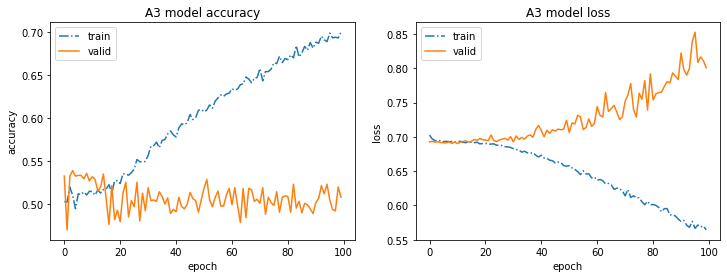

In [54]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_a3.history['accuracy'],linestyle='-.')
plt.plot(history_a3.history['val_accuracy'])
plt.title('A3 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.subplot(1,2,(2))
plt.plot(history_a3.history['loss'],linestyle='-.')
plt.plot(history_a3.history['val_loss'])
plt.title('A3 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [55]:
# evaluate the model
_, train_acc_a3 = model_a3.evaluate(X_train, Y_train, verbose=0)
_, val_acc_a3   = model_a3.evaluate(X_val, Y_val, verbose=0)
_, test_acc_a3  = model_a3.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_a3, val_acc_a3, test_acc_a3))

Train: 0.7389, Val: 0.5083, Test: 0.5139


In [56]:
res_a3 = pd.DataFrame(
          {'ID': 'A3',
           'Type': '1D CNN',
           'Timesteps': n_steps_set1,
           'Train Acc': train_acc_a3,
           'Val Acc': val_acc_a3,
           'Test Acc': test_acc_a3}, index=['A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned'])

pd.concat([res_a1,res_a2,res_a3])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234
A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned,A3,1D CNN,8,0.73894900,0.50828731,0.51385587


***
### A4) 1D CNN - scaled - without dilation - 16 timesteps - tuned v1
- input: log_return_scaled
- target: sign (up/down, 1 or 0) 
- dilation rate: no dilation
- timesteps: 16

In [57]:
model_a4 = Sequential()
ks = 3
model_a4.add(BatchNormalization(input_shape=(n_steps_set2,1)))
#model_a4.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model_a4.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', activation='relu'))
model_a4.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model_a4.add(BatchNormalization())
model_a4.add(Activation('relu'))
#---
model_a4.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', activation='relu'))
model_a4.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model_a4.add(BatchNormalization())
model_a4.add(Activation('relu'))
model_a4.add(MaxPooling1D((2)))
#---
model_a4.add(Convolution1D(filters=64, kernel_size=ks, padding='causal', activation='relu'))
model_a4.add(BatchNormalization())
model_a4.add(Activation('relu'))
#---
model_a4.add(Convolution1D(filters=64, kernel_size=ks, padding='causal'))
model_a4.add(BatchNormalization())
model_a4.add(Activation('relu'))
model_a4.add(MaxPooling1D((2)))
#---
model_a4.add(Flatten())
model_a4.add(Dropout(0.3))

model_a4.add(Dense(32, activation='relu'))
model_a4.add(Dropout(0.3))

model_a4.add(Dense(32, activation='relu'))
model_a4.add(Dropout(0.2))

model_a4.add(Dense(1, activation='sigmoid'))
model_a4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_a4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 16, 1)             4         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 16, 32)            128       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 16, 32)            3104      
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 32)            128       
_________________________________________________________________
activation_4 (Activation)    (None, 16, 32)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 16, 32)            3104      
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 16, 32)           

In [58]:
# define the input & target dataset
# check that we're using the right input set
X = X_logret_set2_scaled
Y = Y_sign_set2
n_steps_set2, X[0:1], Y[0:1]

(16, array([[[0.71644023],
         [0.6830203 ],
         [0.7028579 ],
         [0.71013183],
         [0.69553951],
         [0.68279487],
         [0.70043513],
         [0.70624829],
         [0.70177252],
         [0.70062114],
         [0.6860502 ],
         [0.710541  ],
         [0.71981492],
         [0.71766553],
         [0.66708769],
         [0.68055014]]]), array([[[0.]]]))

In [59]:
# split data into train, val and test
X_train = X[0:train_id]
Y_train = Y[0:train_id]
X_val   = X[train_id:val_id]
Y_val   = Y[train_id:val_id]
X_test  = X[val_id:]
Y_test  = Y[val_id:]
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(8868, 16, 1) (8868, 1, 1)
(1267, 16, 1) (1267, 1, 1)
(2518, 16, 1) (2518, 1, 1)


In [60]:
history_a4 = model_a4.fit(X_train, Y_train,
                          epochs=100,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/100
70/70 [==============================] - 1s 14ms/step - loss: 0.7178 - accuracy: 0.5025 - val_loss: 0.6925 - val_accuracy: 0.5351
Epoch 2/100
70/70 [==============================] - 1s 8ms/step - loss: 0.7001 - accuracy: 0.5077 - val_loss: 0.6923 - val_accuracy: 0.5351
Epoch 3/100
70/70 [==============================] - 1s 9ms/step - loss: 0.6963 - accuracy: 0.5122 - val_loss: 0.6912 - val_accuracy: 0.5351
Epoch 4/100
70/70 [==============================] - 1s 8ms/step - loss: 0.6953 - accuracy: 0.5156 - val_loss: 0.6915 - val_accuracy: 0.5351
Epoch 5/100
70/70 [==============================] - 1s 9ms/step - loss: 0.6949 - accuracy: 0.5020 - val_loss: 0.6912 - val_accuracy: 0.5351
Epoch 6/100
70/70 [==============================] - 1s 8ms/step - loss: 0.6937 - accuracy: 0.5108 - val_loss: 0.6915 - val_accuracy: 0.5351
Epoch 7/100
70/70 [==============================] - 1s 9ms/step - loss: 0.6936 - accuracy: 0.5069 - val_loss: 0.6916 - val_accuracy: 0.5375
Epoch 8/100


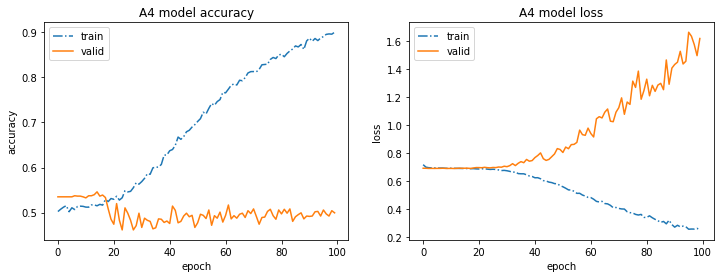

In [61]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_a4.history['accuracy'],linestyle='-.')
plt.plot(history_a4.history['val_accuracy'])
plt.title('A4 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.subplot(1,2,(2))
plt.plot(history_a4.history['loss'],linestyle='-.')
plt.plot(history_a4.history['val_loss'])
plt.title('A4 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [62]:
# evaluate the model
_, train_acc_a4 = model_a4.evaluate(X_train, Y_train, verbose=0)
_, val_acc_a4   = model_a4.evaluate(X_val, Y_val, verbose=0)
_, test_acc_a4  = model_a4.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_a4, val_acc_a4, test_acc_a4))

Train: 0.9295, Val: 0.4996, Test: 0.5143


In [63]:
res_a4 = pd.DataFrame(
          {'ID': 'A4',
           'Type': '1D CNN',
           'Timesteps': n_steps_set2,
           'Train Acc': train_acc_a4,
           'Val Acc': val_acc_a4,
           'Test Acc': test_acc_a4}, index=['A4: 1D CNN - scaled - without dilation - 16 timesteps - tuned v1'])

pd.concat([res_a1,res_a2,res_a3,res_a4])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234
A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned,A3,1D CNN,8,0.73894900,0.50828731,0.51385587
A4: 1D CNN - scaled - without dilation - 16 timesteps - tuned v1,A4,1D CNN,16,0.92952186,0.49960536,0.51429707


***
### A5) 1D CNN - scaled - without dilation - 16 timesteps - tuned v2
- input: log_return_scaled
- target: sign (up/down, 1 or 0) 
- dilation rate: no dilation
- timesteps: 16

In [64]:
model_a5 = Sequential()
ks = 3
model_a5.add(BatchNormalization(input_shape=(n_steps_set2,1)))
model_a5.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', activation='relu'))
model_a5.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model_a5.add(BatchNormalization())
model_a5.add(Activation('relu'))
#---
model_a5.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', activation='relu'))
model_a5.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model_a5.add(BatchNormalization())
model_a5.add(Activation('relu'))
model_a5.add(MaxPooling1D((2)))
#---
model_a5.add(Convolution1D(filters=64, kernel_size=ks, padding='causal', activation='relu'))
model_a5.add(BatchNormalization())
model_a5.add(Activation('relu'))
#---
model_a5.add(Convolution1D(filters=64, kernel_size=ks, padding='causal'))
model_a5.add(BatchNormalization())
model_a5.add(Activation('relu'))
model_a5.add(MaxPooling1D((2)))
#---
model_a5.add(Flatten())
model_a5.add(Dropout(0.3))

model_a5.add(Dense(512, activation='relu'))
model_a5.add(Dropout(0.3))

model_a5.add(Dense(256, activation='relu'))
model_a5.add(Dropout(0.2))

model_a5.add(Dense(1, activation='sigmoid'))

model_a5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_a5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_10 (Batc (None, 16, 1)             4         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 16, 32)            128       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 16, 32)            3104      
_________________________________________________________________
batch_normalization_11 (Batc (None, 16, 32)            128       
_________________________________________________________________
activation_8 (Activation)    (None, 16, 32)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 16, 32)            3104      
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16, 32)           

In [65]:
# define the input & target dataset
# check that we're using the right input set
X = X_logret_set2_scaled
Y = Y_sign_set2
n_steps_set2, X[0:1], Y[0:1]

(16, array([[[0.71644023],
         [0.6830203 ],
         [0.7028579 ],
         [0.71013183],
         [0.69553951],
         [0.68279487],
         [0.70043513],
         [0.70624829],
         [0.70177252],
         [0.70062114],
         [0.6860502 ],
         [0.710541  ],
         [0.71981492],
         [0.71766553],
         [0.66708769],
         [0.68055014]]]), array([[[0.]]]))

In [66]:
# split data into train, val and test
X_train = X[0:train_id]
Y_train = Y[0:train_id]
X_val   = X[train_id:val_id]
Y_val   = Y[train_id:val_id]
X_test  = X[val_id:]
Y_test  = Y[val_id:]
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(8868, 16, 1) (8868, 1, 1)
(1267, 16, 1) (1267, 1, 1)
(2518, 16, 1) (2518, 1, 1)


In [67]:
history_a5 = model_a5.fit(X_train, Y_train,
                          epochs=100,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/100
70/70 [==============================] - 1s 10ms/step - loss: 0.7265 - accuracy: 0.5021 - val_loss: 0.6927 - val_accuracy: 0.5351
Epoch 2/100
70/70 [==============================] - 1s 8ms/step - loss: 0.6992 - accuracy: 0.5105 - val_loss: 0.6944 - val_accuracy: 0.4649
Epoch 3/100
70/70 [==============================] - 1s 11ms/step - loss: 0.6967 - accuracy: 0.5092 - val_loss: 0.6925 - val_accuracy: 0.5351
Epoch 4/100
70/70 [==============================] - 1s 7ms/step - loss: 0.6945 - accuracy: 0.5239 - val_loss: 0.6906 - val_accuracy: 0.5351
Epoch 5/100
70/70 [==============================] - 1s 9ms/step - loss: 0.6926 - accuracy: 0.5204 - val_loss: 0.6908 - val_accuracy: 0.5343
Epoch 6/100
70/70 [==============================] - 1s 9ms/step - loss: 0.6914 - accuracy: 0.5281 - val_loss: 0.6916 - val_accuracy: 0.5335
Epoch 7/100
70/70 [==============================] - 1s 7ms/step - loss: 0.6917 - accuracy: 0.5325 - val_loss: 0.6913 - val_accuracy: 0.5406
Epoch 8/100

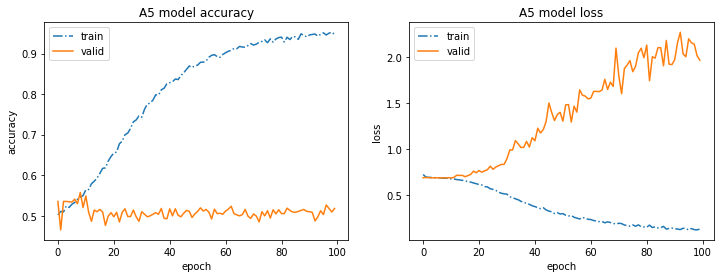

In [68]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_a5.history['accuracy'],linestyle='-.')
plt.plot(history_a5.history['val_accuracy'])
plt.title('A5 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.subplot(1,2,(2))
plt.plot(history_a5.history['loss'],linestyle='-.')
plt.plot(history_a5.history['val_loss'])
plt.title('A5 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [69]:
# evaluate the model
_, train_acc_a5 = model_a5.evaluate(X_train, Y_train, verbose=0)
_, val_acc_a5   = model_a5.evaluate(X_val, Y_val, verbose=0)
_, test_acc_a5  = model_a5.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_a5, val_acc_a5, test_acc_a5))

Train: 0.9835, Val: 0.5178, Test: 0.4833


In [70]:
res_a5 = pd.DataFrame(
          {'ID': 'A5',
           'Type': '1D CNN',
           'Timesteps': n_steps_set2,
           'Train Acc': train_acc_a5,
           'Val Acc': val_acc_a5,
           'Test Acc': test_acc_a5}, index=['A5: 1D CNN - scaled - without dilation - 16 timesteps - tuned v2'])

pd.concat([res_a1,res_a2,res_a3,res_a4,res_a5])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234
A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned,A3,1D CNN,8,0.73894900,0.50828731,0.51385587
A4: 1D CNN - scaled - without dilation - 16 timesteps - tuned v1,A4,1D CNN,16,0.92952186,0.49960536,0.51429707
A5: 1D CNN - scaled - without dilation - 16 timesteps - tuned v2,A5,1D CNN,16,0.98353630,0.51775849,0.48332009


***
### A6) 1D CNN - scaled - with dilation - 16 timesteps - tuned
- input: log_return_scaled
- target: sign (up/down, 1 or 0) 
- dilation rate: dilation
- timesteps: 16

In [71]:
model_a6 = Sequential()
ks = 3
model_a6.add(BatchNormalization(input_shape=(n_steps_set2,1)))
model_a6.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', activation='relu'))
model_a6.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', activation='relu', dilation_rate=2))
model_a6.add(BatchNormalization())
model_a6.add(Activation('relu'))
#---
model_a6.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', activation='relu', dilation_rate=4))
model_a6.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', activation='relu', dilation_rate=8))
model_a6.add(BatchNormalization())
model_a6.add(Activation('relu'))
model_a6.add(MaxPooling1D((2)))
#---
model_a6.add(Convolution1D(filters=64, kernel_size=ks, padding='causal', activation='relu'))
model_a6.add(BatchNormalization())
model_a6.add(Activation('relu'))
#---
model_a6.add(Convolution1D(filters=64, kernel_size=ks, padding='causal'))
model_a6.add(BatchNormalization())
model_a6.add(Activation('relu'))
model_a6.add(MaxPooling1D((2)))
#---
model_a6.add(Flatten())
model_a6.add(Dropout(0.3))

model_a6.add(Dense(32, activation='relu'))
model_a6.add(Dropout(0.3))

model_a6.add(Dense(32, activation='relu'))
model_a6.add(Dropout(0.2))

model_a6.add(Dense(1, activation='sigmoid'))

model_a6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_a6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_15 (Batc (None, 16, 1)             4         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 16, 32)            128       
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 16, 32)            3104      
_________________________________________________________________
batch_normalization_16 (Batc (None, 16, 32)            128       
_________________________________________________________________
activation_12 (Activation)   (None, 16, 32)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 16, 32)            3104      
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 16, 32)           

In [72]:
# define the input & target dataset
# check that we're using the right input set
X = X_logret_set2_scaled
Y = Y_sign_set2
n_steps_set2, X[0:1], Y[0:1]

(16, array([[[0.71644023],
         [0.6830203 ],
         [0.7028579 ],
         [0.71013183],
         [0.69553951],
         [0.68279487],
         [0.70043513],
         [0.70624829],
         [0.70177252],
         [0.70062114],
         [0.6860502 ],
         [0.710541  ],
         [0.71981492],
         [0.71766553],
         [0.66708769],
         [0.68055014]]]), array([[[0.]]]))

In [73]:
# split data into train, val and test
X_train = X[0:train_id]
Y_train = Y[0:train_id]
X_val   = X[train_id:val_id]
Y_val   = Y[train_id:val_id]
X_test  = X[val_id:]
Y_test  = Y[val_id:]
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(8868, 16, 1) (8868, 1, 1)
(1267, 16, 1) (1267, 1, 1)
(2518, 16, 1) (2518, 1, 1)


In [74]:
history_a6 = model_a6.fit(X_train, Y_train,
                          epochs=100,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/100
70/70 [==============================] - 1s 13ms/step - loss: 0.7213 - accuracy: 0.4983 - val_loss: 0.6928 - val_accuracy: 0.5351
Epoch 2/100
70/70 [==============================] - 1s 8ms/step - loss: 0.6986 - accuracy: 0.4999 - val_loss: 0.6925 - val_accuracy: 0.5351
Epoch 3/100
70/70 [==============================] - 1s 8ms/step - loss: 0.6953 - accuracy: 0.5081 - val_loss: 0.6925 - val_accuracy: 0.5351
Epoch 4/100
70/70 [==============================] - 1s 9ms/step - loss: 0.6944 - accuracy: 0.4992 - val_loss: 0.6924 - val_accuracy: 0.5351
Epoch 5/100
70/70 [==============================] - 1s 8ms/step - loss: 0.6936 - accuracy: 0.5100 - val_loss: 0.6915 - val_accuracy: 0.5351
Epoch 6/100
70/70 [==============================] - 1s 9ms/step - loss: 0.6933 - accuracy: 0.5170 - val_loss: 0.6918 - val_accuracy: 0.5351
Epoch 7/100
70/70 [==============================] - 1s 8ms/step - loss: 0.6937 - accuracy: 0.5149 - val_loss: 0.6911 - val_accuracy: 0.5351
Epoch 8/100


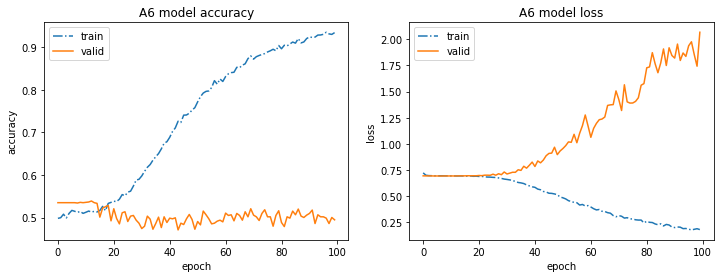

In [75]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_a6.history['accuracy'],linestyle='-.')
plt.plot(history_a6.history['val_accuracy'])
plt.title('A6 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.subplot(1,2,(2))
plt.plot(history_a6.history['loss'],linestyle='-.')
plt.plot(history_a6.history['val_loss'])
plt.title('A6 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [76]:
# evaluate the model
_, train_acc_a6 = model_a6.evaluate(X_train, Y_train, verbose=0)
_, val_acc_a6   = model_a6.evaluate(X_val, Y_val, verbose=0)
_, test_acc_a6  = model_a6.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_a6, val_acc_a6, test_acc_a6))

Train: 0.9605, Val: 0.4949, Test: 0.5119


In [77]:
res_a6 = pd.DataFrame(
          {'ID': 'A6',
           'Type': '1D CNN',
           'Timesteps': n_steps_set2,
           'Train Acc': train_acc_a6,
           'Val Acc': val_acc_a6,
           'Test Acc': test_acc_a6}, index=['A6: 1D CNN - scaled - with dilation - 16 timesteps - tuned'])

pd.concat([res_a1,res_a2,res_a3,res_a4,res_a5,res_a6])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234
A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned,A3,1D CNN,8,0.73894900,0.50828731,0.51385587
A4: 1D CNN - scaled - without dilation - 16 timesteps - tuned v1,A4,1D CNN,16,0.92952186,0.49960536,0.51429707
A5: 1D CNN - scaled - without dilation - 16 timesteps - tuned v2,A5,1D CNN,16,0.98353630,0.51775849,0.48332009
A6: 1D CNN - scaled - with dilation - 16 timesteps - tuned,A6,1D CNN,16,0.96053225,0.49486977,0.51191419


***
# 5. SECTION B: fcNN

### B1) fcNN - scaled - 8 timesteps

In [0]:
# choose number of days for input data set (e.g. 8 previous days will used to predict the next day's value)
n_steps_set1 = 8
# set number of features (in our case 1)
n_features = 1

In [0]:
# split data into input (log_return) and target (sign of log_return = up or down = 1 or 0)
X_logret_set1, Y_sign_set1 = split_sequence(raw_seq_log_return, n_steps_set1, sign=True)
# summarize the data
#for i in range(len(X_logret_set1)):
#    print(X_logret_set1[i], Y_sign_set1[i])

In [80]:
# add scaled X using MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X_logret_set1_scaled = sc.fit_transform(X_logret_set1)
# and check the shape again and some values
print(X_logret_set1_scaled.shape)
print(X_logret_set1_scaled[0:2])
print(X_logret_set1[0:2])

(12661, 8)
[[0.71644023 0.6830203  0.7028579  0.70513739 0.6906477  0.67799269
  0.69550889 0.70128116]
 [0.6830203  0.7028579  0.71013183 0.6906477  0.67799269 0.69550889
  0.70128116 0.69683687]]
[[ 0.0026041  -0.00947396 -0.00230459  0.00032423 -0.00494948 -0.00955543
  -0.00318019 -0.0010793 ]
 [-0.00947396 -0.00230459  0.00032423 -0.00494948 -0.00955543 -0.00318019
  -0.0010793  -0.00269685]]


In [81]:
# define the input & target dataset
# check that we're using the right input set
X = X_logret_set1_scaled
Y = Y_sign_set1
n_steps_set1, X[0:1], Y[0:1]

(8, array([[0.71644023, 0.6830203 , 0.7028579 , 0.70513739, 0.6906477 ,
         0.67799269, 0.69550889, 0.70128116]]), array([0.]))

In [82]:
# split data into train, val and test
X_train = X[0:train_id]
Y_train = Y[0:train_id]
X_val   = X[train_id:val_id]
Y_val   = Y[train_id:val_id]
X_test  = X[val_id:]
Y_test  = Y[val_id:]
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(8868, 8) (8868,)
(1267, 8) (1267,)
(2526, 8) (2526,)


In [83]:
model_b1 = Sequential()
model_b1.add(Dense(128, batch_input_shape=(None, n_steps_set1),activation='relu'))
model_b1.add(BatchNormalization())

model_b1.add(Dense(128))
model_b1.add(BatchNormalization())
model_b1.add(Activation('relu'))

model_b1.add(Dense(256))
model_b1.add(BatchNormalization())
model_b1.add(Activation('relu'))
model_b1.add(Dense(256))
model_b1.add(BatchNormalization())
model_b1.add(Activation('relu'))

model_b1.add(Dense(1, activation='sigmoid'))
model_b1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_b1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               1152      
_________________________________________________________________
batch_normalization_20 (Batc (None, 128)               512       
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_21 (Batc (None, 128)               512       
_________________________________________________________________
activation_16 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_22 (Batc (None, 256)              

In [84]:
history_b1 = model_b1.fit(X_train, Y_train,
                          epochs=100,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/100
70/70 [==============================] - 1s 8ms/step - loss: 0.7359 - accuracy: 0.5133 - val_loss: 0.6955 - val_accuracy: 0.4672
Epoch 2/100
70/70 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5482 - val_loss: 0.6994 - val_accuracy: 0.4688
Epoch 3/100
70/70 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5653 - val_loss: 0.6961 - val_accuracy: 0.4633
Epoch 4/100
70/70 [==============================] - 0s 6ms/step - loss: 0.6778 - accuracy: 0.5719 - val_loss: 0.6947 - val_accuracy: 0.5312
Epoch 5/100
70/70 [==============================] - 0s 6ms/step - loss: 0.6733 - accuracy: 0.5833 - val_loss: 0.7004 - val_accuracy: 0.5335
Epoch 6/100
70/70 [==============================] - 0s 6ms/step - loss: 0.6659 - accuracy: 0.5979 - val_loss: 0.7000 - val_accuracy: 0.4996
Epoch 7/100
70/70 [==============================] - 0s 6ms/step - loss: 0.6598 - accuracy: 0.5991 - val_loss: 0.7107 - val_accuracy: 0.4665
Epoch 8/100
7

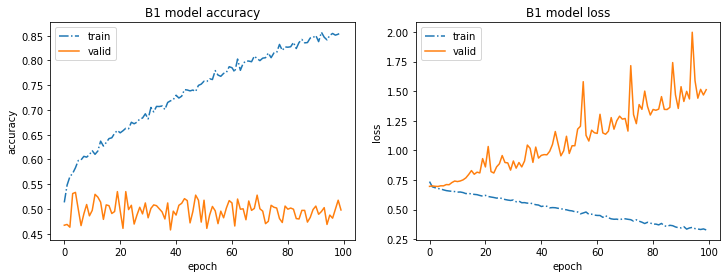

In [85]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_b1.history['accuracy'],linestyle='-.')
plt.plot(history_b1.history['val_accuracy'])
plt.title('B1 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.subplot(1,2,(2))
plt.plot(history_b1.history['loss'],linestyle='-.')
plt.plot(history_b1.history['val_loss'])
plt.title('B1 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [86]:
# evaluate the model
_, train_acc_b1 = model_b1.evaluate(X_train, Y_train, verbose=0)
_, val_acc_b1   = model_b1.evaluate(X_val, Y_val, verbose=0)
_, test_acc_b1  = model_b1.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_b1, val_acc_b1, test_acc_b1))

Train: 0.6582, Val: 0.4980, Test: 0.5040


In [87]:
res_b1 = pd.DataFrame(
          {'ID': 'B1',
           'Type': 'fcNN',
           'Timesteps': n_steps_set1,
           'Train Acc': train_acc_b1,
           'Val Acc': val_acc_b1,
           'Test Acc': test_acc_b1}, index=['B1: fcNN - scaled - 8 timesteps'])

pd.concat([res_a1,res_a2,res_a3,res_a4,res_a5,res_a6,res_b1])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234
A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned,A3,1D CNN,8,0.73894900,0.50828731,0.51385587
A4: 1D CNN - scaled - without dilation - 16 timesteps - tuned v1,A4,1D CNN,16,0.92952186,0.49960536,0.51429707
A5: 1D CNN - scaled - without dilation - 16 timesteps - tuned v2,A5,1D CNN,16,0.98353630,0.51775849,0.48332009
A6: 1D CNN - scaled - with dilation - 16 timesteps - tuned,A6,1D CNN,16,0.96053225,0.49486977,0.51191419
B1: fcNN - scaled - 8 timesteps,B1,fcNN,8,0.65820926,0.49802685,0.50395882


### B2) fcNN - scaled - 8 timesteps - with dropout

In [88]:
model_b2 = Sequential()
model_b2.add(Dense(128, batch_input_shape=(None, n_steps_set1),activation='relu'))
model_b2.add(BatchNormalization())

model_b2.add(Dense(128))
model_b2.add(BatchNormalization())
model_b2.add(Activation('relu'))
model_b2.add(Dropout(0.3))

model_b2.add(Dense(256))
model_b2.add(BatchNormalization())
model_b2.add(Activation('relu'))
model_b2.add(Dense(256))
model_b2.add(BatchNormalization())
model_b2.add(Activation('relu'))
model_b2.add(Dropout(0.3))

model_b2.add(Dense(512))
model_b2.add(BatchNormalization())
model_b2.add(Activation('relu'))
model_b2.add(Dense(512))
model_b2.add(BatchNormalization())
model_b2.add(Activation('relu'))
model_b2.add(Dropout(0.3))

model_b2.add(Dense(100))
model_b2.add(Dense(1, activation='sigmoid'))
model_b2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_b2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               1152      
_________________________________________________________________
batch_normalization_24 (Batc (None, 128)               512       
_________________________________________________________________
dense_21 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_25 (Batc (None, 128)               512       
_________________________________________________________________
activation_19 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)              

In [89]:
history_b2 = model_b2.fit(X_train, Y_train,
                          epochs=100,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/100
70/70 [==============================] - 1s 11ms/step - loss: 0.8166 - accuracy: 0.5050 - val_loss: 0.6945 - val_accuracy: 0.4672
Epoch 2/100
70/70 [==============================] - 1s 8ms/step - loss: 0.7240 - accuracy: 0.5182 - val_loss: 0.6991 - val_accuracy: 0.4680
Epoch 3/100
70/70 [==============================] - 0s 7ms/step - loss: 0.7222 - accuracy: 0.5149 - val_loss: 0.7381 - val_accuracy: 0.4672
Epoch 4/100
70/70 [==============================] - 1s 7ms/step - loss: 0.7216 - accuracy: 0.5088 - val_loss: 0.6929 - val_accuracy: 0.5264
Epoch 5/100
70/70 [==============================] - 0s 7ms/step - loss: 0.7133 - accuracy: 0.5152 - val_loss: 0.6947 - val_accuracy: 0.5233
Epoch 6/100
70/70 [==============================] - 0s 7ms/step - loss: 0.7129 - accuracy: 0.5151 - val_loss: 0.7038 - val_accuracy: 0.5320
Epoch 7/100
70/70 [==============================] - 0s 7ms/step - loss: 0.7059 - accuracy: 0.5179 - val_loss: 0.7092 - val_accuracy: 0.4538
Epoch 8/100


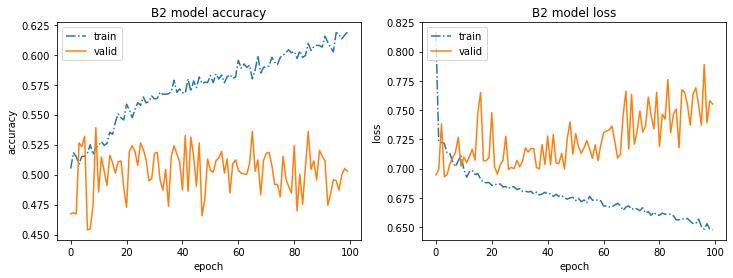

In [90]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_b2.history['accuracy'],linestyle='-.')
plt.plot(history_b2.history['val_accuracy'])
plt.title('B2 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.subplot(1,2,(2))
plt.plot(history_b2.history['loss'],linestyle='-.')
plt.plot(history_b2.history['val_loss'])
plt.title('B2 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [91]:
# evaluate the model
_, train_acc_b2 = model_b2.evaluate(X_train, Y_train, verbose=0)
_, val_acc_b2   = model_b2.evaluate(X_val, Y_val, verbose=0)
_, test_acc_b2  = model_b2.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_b2, val_acc_b2, test_acc_b2))

Train: 0.5562, Val: 0.5028, Test: 0.5012


In [92]:
res_b2 = pd.DataFrame(
          {'ID': 'B2',
           'Type': 'fcNN',
           'Timesteps': n_steps_set1,
           'Train Acc': train_acc_b2,
           'Val Acc': val_acc_b2,
           'Test Acc': test_acc_b2}, index=['B2: fcNN - scaled - 8 timesteps - with dropout'])

pd.concat([res_a1,res_a2,res_a3,res_a4,res_a5,res_a6,res_b1,res_b2])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234
A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned,A3,1D CNN,8,0.73894900,0.50828731,0.51385587
A4: 1D CNN - scaled - without dilation - 16 timesteps - tuned v1,A4,1D CNN,16,0.92952186,0.49960536,0.51429707
A5: 1D CNN - scaled - without dilation - 16 timesteps - tuned v2,A5,1D CNN,16,0.98353630,0.51775849,0.48332009
A6: 1D CNN - scaled - with dilation - 16 timesteps - tuned,A6,1D CNN,16,0.96053225,0.49486977,0.51191419
B1: fcNN - scaled - 8 timesteps,B1,fcNN,8,0.65820926,0.49802685,0.50395882
B2: fcNN - scaled - 8 timesteps - with dropout,B2,fcNN,8,0.55615699,0.50276244,0.50118762


### B3) fcNN - scaled - 16 timesteps

In [0]:
# choose number of days for input data set (e.g. 8 previous days will used to predict the next day's value)
n_steps_set2 = 16
# set number of features (in our case 1)
n_features = 1

In [0]:
# split data into input (log_return) and target (sign of log_return = up or down = 1 or 0)
X_logret_set2, Y_sign_set2 = split_sequence(raw_seq_log_return, n_steps_set2, sign=True)
# summarize the data
#for i in range(len(X_logret_set2)):
#    print(X_logret_set2[i], Y_sign_set2[i])

In [95]:
# add scaled X using MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X_logret_set2_scaled = sc.fit_transform(X_logret_set2)
# and check the shape again and some values
print(X_logret_set2_scaled.shape)
print(X_logret_set2_scaled[0:2])
print(X_logret_set2[0:2])

(12653, 16)
[[0.71644023 0.6830203  0.7028579  0.71013183 0.69553951 0.68279487
  0.70043513 0.70624829 0.70177252 0.70062114 0.6860502  0.710541
  0.71981492 0.71766553 0.66708769 0.68055014]
 [0.6830203  0.7028579  0.71013183 0.69553951 0.68279487 0.70043513
  0.70624829 0.70177252 0.70062114 0.6860502  0.71557371 0.71981492
  0.71766553 0.66708769 0.68055014 0.68671667]]
[[ 0.0026041  -0.00947396 -0.00230459  0.00032423 -0.00494948 -0.00955543
  -0.00318019 -0.0010793  -0.00269685 -0.00311297 -0.00837895  0.00229094
   0.0056663   0.00488401 -0.01352445 -0.00862462]
 [-0.00947396 -0.00230459  0.00032423 -0.00494948 -0.00955543 -0.00318019
  -0.0010793  -0.00269685 -0.00311297 -0.00837895  0.00229094  0.0056663
   0.00488401 -0.01352445 -0.00862462 -0.00638023]]


In [96]:
# define the input & target dataset
# check that we're using the right input set
X = X_logret_set2_scaled
Y = Y_sign_set2
n_steps_set2, X[0:1], Y[0:1]

(16, array([[0.71644023, 0.6830203 , 0.7028579 , 0.71013183, 0.69553951,
         0.68279487, 0.70043513, 0.70624829, 0.70177252, 0.70062114,
         0.6860502 , 0.710541  , 0.71981492, 0.71766553, 0.66708769,
         0.68055014]]), array([0.]))

In [97]:
# split data into train, val and test
X_train = X[0:train_id]
Y_train = Y[0:train_id]
X_val   = X[train_id:val_id]
Y_val   = Y[train_id:val_id]
X_test  = X[val_id:]
Y_test  = Y[val_id:]
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(8868, 16) (8868,)
(1267, 16) (1267,)
(2518, 16) (2518,)


In [98]:
model_b3 = Sequential()
model_b3.add(Dense(128, batch_input_shape=(None, n_steps_set2),activation='relu'))
model_b3.add(BatchNormalization())

model_b3.add(Dense(128))
model_b3.add(BatchNormalization())
model_b3.add(Activation('relu'))

model_b3.add(Dense(256))
model_b3.add(BatchNormalization())
model_b3.add(Activation('relu'))
model_b3.add(Dense(256))
model_b3.add(BatchNormalization())
model_b3.add(Activation('relu'))

model_b3.add(Dense(1, activation='sigmoid'))
model_b3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_b3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 128)               2176      
_________________________________________________________________
batch_normalization_30 (Batc (None, 128)               512       
_________________________________________________________________
dense_29 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_31 (Batc (None, 128)               512       
_________________________________________________________________
activation_24 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_32 (Batc (None, 256)              

In [99]:
history_b3 = model_b3.fit(X_train, Y_train,
                          epochs=100,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/100
70/70 [==============================] - 1s 7ms/step - loss: 0.7550 - accuracy: 0.4989 - val_loss: 0.6921 - val_accuracy: 0.5351
Epoch 2/100
70/70 [==============================] - 0s 7ms/step - loss: 0.6842 - accuracy: 0.5598 - val_loss: 0.6979 - val_accuracy: 0.4625
Epoch 3/100
70/70 [==============================] - 0s 6ms/step - loss: 0.6648 - accuracy: 0.5889 - val_loss: 0.7029 - val_accuracy: 0.4617
Epoch 4/100
70/70 [==============================] - 0s 5ms/step - loss: 0.6487 - accuracy: 0.6204 - val_loss: 0.7208 - val_accuracy: 0.4578
Epoch 5/100
70/70 [==============================] - 0s 6ms/step - loss: 0.6338 - accuracy: 0.6404 - val_loss: 0.7107 - val_accuracy: 0.4554
Epoch 6/100
70/70 [==============================] - 0s 7ms/step - loss: 0.6220 - accuracy: 0.6488 - val_loss: 0.7431 - val_accuracy: 0.4617
Epoch 7/100
70/70 [==============================] - 1s 7ms/step - loss: 0.6105 - accuracy: 0.6572 - val_loss: 0.7301 - val_accuracy: 0.4783
Epoch 8/100
7

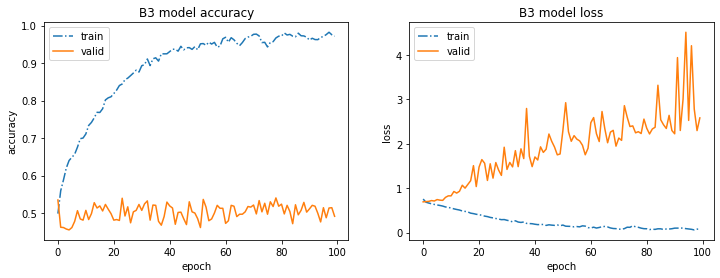

In [100]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_b3.history['accuracy'],linestyle='-.')
plt.plot(history_b3.history['val_accuracy'])
plt.title('B3 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.subplot(1,2,(2))
plt.plot(history_b3.history['loss'],linestyle='-.')
plt.plot(history_b3.history['val_loss'])
plt.title('B3 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [101]:
# evaluate the model
_, train_acc_b3 = model_b3.evaluate(X_train, Y_train, verbose=0)
_, val_acc_b3   = model_b3.evaluate(X_val, Y_val, verbose=0)
_, test_acc_b3  = model_b3.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_b3, val_acc_b3, test_acc_b3))

Train: 0.6425, Val: 0.4917, Test: 0.4861


In [102]:
res_b3 = pd.DataFrame(
          {'ID': 'B3',
           'Type': 'fcNN',
           'Timesteps': n_steps_set2,
           'Train Acc': train_acc_b3,
           'Val Acc': val_acc_b3,
           'Test Acc': test_acc_b3}, index=['B3: fcNN - scaled - 16 timesteps'])

pd.concat([res_a1,res_a2,res_a3,res_a4,res_a5,res_a6,res_b1,res_b2,res_b3])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234
A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned,A3,1D CNN,8,0.73894900,0.50828731,0.51385587
A4: 1D CNN - scaled - without dilation - 16 timesteps - tuned v1,A4,1D CNN,16,0.92952186,0.49960536,0.51429707
A5: 1D CNN - scaled - without dilation - 16 timesteps - tuned v2,A5,1D CNN,16,0.98353630,0.51775849,0.48332009
A6: 1D CNN - scaled - with dilation - 16 timesteps - tuned,A6,1D CNN,16,0.96053225,0.49486977,0.51191419
B1: fcNN - scaled - 8 timesteps,B1,fcNN,8,0.65820926,0.49802685,0.50395882
B2: fcNN - scaled - 8 timesteps - with dropout,B2,fcNN,8,0.55615699,0.50276244,0.50118762
B3: fcNN - scaled - 16 timesteps,B3,fcNN,16,0.64253497,0.49171272,0.48610008


### B4) fcNN - scaled - 16 timesteps - with dropout

In [103]:
model_b4 = Sequential()
model_b4.add(Dense(128, batch_input_shape=(None, n_steps_set2),activation='relu'))
model_b4.add(BatchNormalization())

model_b4.add(Dense(128))
model_b4.add(BatchNormalization())
model_b4.add(Activation('relu'))
model_b4.add(Dropout(0.3))

model_b4.add(Dense(256))
model_b4.add(BatchNormalization())
model_b4.add(Activation('relu'))
model_b4.add(Dense(256))
model_b4.add(BatchNormalization())
model_b4.add(Activation('relu'))
model_b4.add(Dropout(0.3))

model_b4.add(Dense(512))
model_b4.add(BatchNormalization())
model_b4.add(Activation('relu'))
model_b4.add(Dense(512))
model_b4.add(BatchNormalization())
model_b4.add(Activation('relu'))
model_b4.add(Dropout(0.3))

model_b4.add(Dense(100))
model_b4.add(Dense(1, activation='sigmoid'))
model_b4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_b4.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 128)               2176      
_________________________________________________________________
batch_normalization_34 (Batc (None, 128)               512       
_________________________________________________________________
dense_34 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_35 (Batc (None, 128)               512       
_________________________________________________________________
activation_27 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 256)              

In [104]:
history_b4 = model_b4.fit(X_train, Y_train,
                          epochs=100,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/100
70/70 [==============================] - 1s 9ms/step - loss: 0.8106 - accuracy: 0.5032 - val_loss: 0.6906 - val_accuracy: 0.5351
Epoch 2/100
70/70 [==============================] - 1s 8ms/step - loss: 0.7325 - accuracy: 0.5034 - val_loss: 0.7505 - val_accuracy: 0.5351
Epoch 3/100
70/70 [==============================] - 1s 8ms/step - loss: 0.7307 - accuracy: 0.5071 - val_loss: 0.7098 - val_accuracy: 0.4641
Epoch 4/100
70/70 [==============================] - 1s 8ms/step - loss: 0.7143 - accuracy: 0.5152 - val_loss: 0.7220 - val_accuracy: 0.5351
Epoch 5/100
70/70 [==============================] - 1s 7ms/step - loss: 0.7140 - accuracy: 0.5145 - val_loss: 0.6921 - val_accuracy: 0.5367
Epoch 6/100
70/70 [==============================] - 1s 7ms/step - loss: 0.7111 - accuracy: 0.5131 - val_loss: 0.6976 - val_accuracy: 0.4815
Epoch 7/100
70/70 [==============================] - 1s 8ms/step - loss: 0.7071 - accuracy: 0.5341 - val_loss: 0.6987 - val_accuracy: 0.4807
Epoch 8/100
7

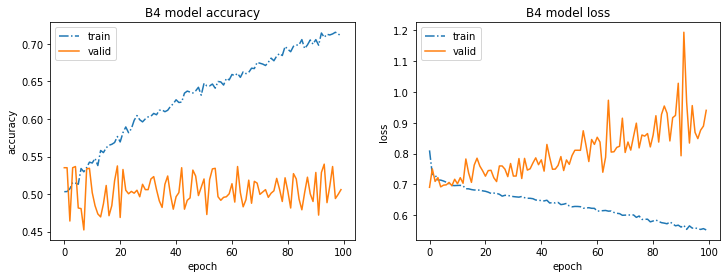

In [105]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_b4.history['accuracy'],linestyle='-.')
plt.plot(history_b4.history['val_accuracy'])
plt.title('B4 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.subplot(1,2,(2))
plt.plot(history_b4.history['loss'],linestyle='-.')
plt.plot(history_b4.history['val_loss'])
plt.title('B4 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [106]:
# evaluate the model
_, train_acc_b4 = model_b4.evaluate(X_train, Y_train, verbose=0)
_, val_acc_b4   = model_b4.evaluate(X_val, Y_val, verbose=0)
_, test_acc_b4  = model_b4.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_b4, val_acc_b4, test_acc_b4))

Train: 0.5659, Val: 0.5059, Test: 0.4992


In [107]:
res_b4 = pd.DataFrame(
          {'ID': 'B4',
           'Type': 'fcNN',
           'Timesteps': n_steps_set2,
           'Train Acc': train_acc_b4,
           'Val Acc': val_acc_b4,
           'Test Acc': test_acc_b4}, index=['B4: fcNN - scaled - 16 timesteps - with dropout'])

pd.concat([res_a1,res_a2,res_a3,res_a4,res_a5,res_a6,res_b1,res_b2,res_b3,res_b4])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234
A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned,A3,1D CNN,8,0.73894900,0.50828731,0.51385587
A4: 1D CNN - scaled - without dilation - 16 timesteps - tuned v1,A4,1D CNN,16,0.92952186,0.49960536,0.51429707
A5: 1D CNN - scaled - without dilation - 16 timesteps - tuned v2,A5,1D CNN,16,0.98353630,0.51775849,0.48332009
A6: 1D CNN - scaled - with dilation - 16 timesteps - tuned,A6,1D CNN,16,0.96053225,0.49486977,0.51191419
B1: fcNN - scaled - 8 timesteps,B1,fcNN,8,0.65820926,0.49802685,0.50395882
B2: fcNN - scaled - 8 timesteps - with dropout,B2,fcNN,8,0.55615699,0.50276244,0.50118762
B3: fcNN - scaled - 16 timesteps,B3,fcNN,16,0.64253497,0.49171272,0.48610008
B4: fcNN - scaled - 16 timesteps - with dropout,B4,fcNN,16,0.56585479,0.50591952,0.49920571


***
# 6. SECTION C: LSTM

In [0]:
# first reload data into 3d shape for LSTM input

### 6.a) Split data for set1 -> timesteps = 8

In [0]:
# choose number of days for input data set (e.g. 8 previous days will used to predict the next day's value)
n_steps_set1 = 8
# set number of features (in our case 1)
n_features = 1

In [0]:
# split data into input (log_return) and target (sign of log_return = up or down = 1 or 0)
X_logret_set1, Y_sign_set1 = split_sequence(raw_seq_log_return, n_steps_set1, sign=True)

In [111]:
# check shape of the data, final shape needs to have 3 dimensions
print(X_logret_set1.shape)
print(Y_sign_set1.shape)

(12661, 8)
(12661,)


In [112]:
# add scaled X using MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X_logret_set1_scaled = sc.fit_transform(X_logret_set1)
# and check the shape again and some values
print(X_logret_set1_scaled.shape)
print(X_logret_set1_scaled[0:2])
print(X_logret_set1[0:2])

(12661, 8)
[[0.71644023 0.6830203  0.7028579  0.70513739 0.6906477  0.67799269
  0.69550889 0.70128116]
 [0.6830203  0.7028579  0.71013183 0.6906477  0.67799269 0.69550889
  0.70128116 0.69683687]]
[[ 0.0026041  -0.00947396 -0.00230459  0.00032423 -0.00494948 -0.00955543
  -0.00318019 -0.0010793 ]
 [-0.00947396 -0.00230459  0.00032423 -0.00494948 -0.00955543 -0.00318019
  -0.0010793  -0.00269685]]


In [113]:
# reshape to fit the final form for input to the NN's
# X from [samples, timesteps] into [samples, timesteps, features]
X_logret_set1 = X_logret_set1.reshape((X_logret_set1.shape[0], X_logret_set1.shape[1], n_features))
X_logret_set1_scaled = X_logret_set1_scaled.reshape((X_logret_set1_scaled.shape[0], X_logret_set1_scaled.shape[1], n_features))
# Y from [samples] into [samples, timesteps, features]
Y_sign_set1 = Y_sign_set1.reshape((len(Y_sign_set1),1))
Y_sign_set1 = Y_sign_set1.reshape((Y_sign_set1.shape[0], Y_sign_set1.shape[1], n_features))
print(X_logret_set1.shape)
print(X_logret_set1_scaled.shape)
print(Y_sign_set1.shape)

(12661, 8, 1)
(12661, 8, 1)
(12661, 1, 1)


### 6.b) Split data for set2 -> timesteps = 16

In [0]:
# choose number of days for input data set (e.g. 8 previous days will used to predict the next day's value)
n_steps_set2 = 16
# set number of features (in our case 1)
n_features = 1

In [0]:
# split data into input (log_return) and target (sign of log_return = up or down = 1 or 0)
X_logret_set2, Y_sign_set2 = split_sequence(raw_seq_log_return, n_steps_set2, sign=True)

In [116]:
# check shape of the data, final shape needs to have 3 dimensions
print(X_logret_set2.shape)
print(Y_sign_set2.shape)

(12653, 16)
(12653,)


In [117]:
# add scaled X using MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X_logret_set2_scaled = sc.fit_transform(X_logret_set2)
# and check the shape again and some values
print(X_logret_set2_scaled.shape)
print(X_logret_set2_scaled[0:2])
print(X_logret_set2[0:2])

(12653, 16)
[[0.71644023 0.6830203  0.7028579  0.71013183 0.69553951 0.68279487
  0.70043513 0.70624829 0.70177252 0.70062114 0.6860502  0.710541
  0.71981492 0.71766553 0.66708769 0.68055014]
 [0.6830203  0.7028579  0.71013183 0.69553951 0.68279487 0.70043513
  0.70624829 0.70177252 0.70062114 0.6860502  0.71557371 0.71981492
  0.71766553 0.66708769 0.68055014 0.68671667]]
[[ 0.0026041  -0.00947396 -0.00230459  0.00032423 -0.00494948 -0.00955543
  -0.00318019 -0.0010793  -0.00269685 -0.00311297 -0.00837895  0.00229094
   0.0056663   0.00488401 -0.01352445 -0.00862462]
 [-0.00947396 -0.00230459  0.00032423 -0.00494948 -0.00955543 -0.00318019
  -0.0010793  -0.00269685 -0.00311297 -0.00837895  0.00229094  0.0056663
   0.00488401 -0.01352445 -0.00862462 -0.00638023]]


In [118]:
# reshape to fit the final form for input to the NN's
# X from [samples, timesteps] into [samples, timesteps, features]
X_logret_set2 = X_logret_set2.reshape((X_logret_set2.shape[0], X_logret_set2.shape[1], n_features))
X_logret_set2_scaled = X_logret_set2_scaled.reshape((X_logret_set2_scaled.shape[0], X_logret_set2_scaled.shape[1], n_features))
# Y from [samples] into [samples, timesteps, features]
Y_sign_set2 = Y_sign_set2.reshape((len(Y_sign_set2),1))
Y_sign_set2 = Y_sign_set2.reshape((Y_sign_set2.shape[0], Y_sign_set2.shape[1], n_features))
print(X_logret_set2.shape)
print(X_logret_set2_scaled.shape)
print(Y_sign_set2.shape)

(12653, 16, 1)
(12653, 16, 1)
(12653, 1, 1)


### C1) LSTM - non-scaled - 8 timesteps - one LSTM layer

In [119]:
model_c1 = Sequential()
model_c1.add(LSTM(50, activation='relu', input_shape=(n_steps_set1,1)))
model_c1.add(Dense(1, activation='sigmoid'))
model_c1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_c1.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [120]:
# define the input & target dataset
# need to reload as LSTM requires 3d input
X = X_logret_set1
Y = Y_sign_set1
n_steps_set1, X[0:1], Y[0:1]

(8, array([[[ 0.0026041 ],
         [-0.00947396],
         [-0.00230459],
         [ 0.00032423],
         [-0.00494948],
         [-0.00955543],
         [-0.00318019],
         [-0.0010793 ]]]), array([[[0.]]]))

In [121]:
# split data into train, val and test
X_train = X[0:train_id]
Y_train = Y[0:train_id]
X_val   = X[train_id:val_id]
Y_val   = Y[train_id:val_id]
X_test  = X[val_id:]
Y_test  = Y[val_id:]
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(8868, 8, 1) (8868, 1, 1)
(1267, 8, 1) (1267, 1, 1)
(2526, 8, 1) (2526, 1, 1)


In [122]:
history_c1 = model_c1.fit(X_train, Y_train,
                          epochs=100,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/100
70/70 [==============================] - 2s 23ms/step - loss: 0.6928 - accuracy: 0.5133 - val_loss: 0.6918 - val_accuracy: 0.5328
Epoch 2/100
70/70 [==============================] - 1s 19ms/step - loss: 0.6929 - accuracy: 0.5133 - val_loss: 0.6918 - val_accuracy: 0.5328
Epoch 3/100
70/70 [==============================] - 1s 16ms/step - loss: 0.6928 - accuracy: 0.5133 - val_loss: 0.6919 - val_accuracy: 0.5328
Epoch 4/100
70/70 [==============================] - 1s 20ms/step - loss: 0.6928 - accuracy: 0.5133 - val_loss: 0.6918 - val_accuracy: 0.5328
Epoch 5/100
70/70 [==============================] - 1s 19ms/step - loss: 0.6929 - accuracy: 0.5133 - val_loss: 0.6918 - val_accuracy: 0.5328
Epoch 6/100
70/70 [==============================] - 1s 17ms/step - loss: 0.6928 - accuracy: 0.5133 - val_loss: 0.6918 - val_accuracy: 0.5328
Epoch 7/100
70/70 [==============================] - 1s 18ms/step - loss: 0.6929 - accuracy: 0.5133 - val_loss: 0.6917 - val_accuracy: 0.5328
Epoch 

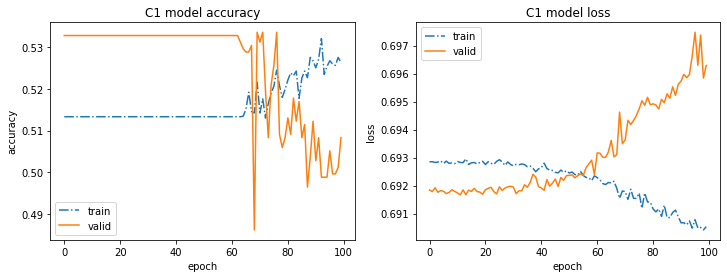

In [123]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_c1.history['accuracy'],linestyle='-.')
plt.plot(history_c1.history['val_accuracy'])
plt.title('C1 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower left')

plt.subplot(1,2,(2))
plt.plot(history_c1.history['loss'],linestyle='-.')
plt.plot(history_c1.history['val_loss'])
plt.title('C1 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [124]:
# evaluate the model
_, train_acc_c1 = model_c1.evaluate(X_train, Y_train, verbose=0)
_, val_acc_c1   = model_c1.evaluate(X_val, Y_val, verbose=0)
_, test_acc_c1  = model_c1.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_c1, val_acc_c1, test_acc_c1))

Train: 0.5221, Val: 0.5083, Test: 0.5178


In [125]:
res_c1 = pd.DataFrame(
          {'ID': 'C1',
           'Type': 'LSTM',
           'Timesteps': n_steps_set1,
           'Train Acc': train_acc_c1,
           'Val Acc': val_acc_c1,
           'Test Acc': test_acc_c1}, index=['C1: LSTM - non-scaled - 8 timesteps - one LSTM layer'])

pd.concat([res_a1,res_a2,res_a3,res_a4,res_a5,res_a6,res_b1,res_b2,res_b3,res_c1])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234
A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned,A3,1D CNN,8,0.73894900,0.50828731,0.51385587
A4: 1D CNN - scaled - without dilation - 16 timesteps - tuned v1,A4,1D CNN,16,0.92952186,0.49960536,0.51429707
A5: 1D CNN - scaled - without dilation - 16 timesteps - tuned v2,A5,1D CNN,16,0.98353630,0.51775849,0.48332009
A6: 1D CNN - scaled - with dilation - 16 timesteps - tuned,A6,1D CNN,16,0.96053225,0.49486977,0.51191419
B1: fcNN - scaled - 8 timesteps,B1,fcNN,8,0.65820926,0.49802685,0.50395882
B2: fcNN - scaled - 8 timesteps - with dropout,B2,fcNN,8,0.55615699,0.50276244,0.50118762
B3: fcNN - scaled - 16 timesteps,B3,fcNN,16,0.64253497,0.49171272,0.48610008
C1: LSTM - non-scaled - 8 timesteps - one LSTM layer,C1,LSTM,8,0.52210194,0.50828731,0.51781476


### C2) LSTM - scaled - 8 timesteps - tuned

In [126]:
model_c2 = Sequential()

model_c2.add(LSTM(25, return_sequences=True, input_shape=(n_steps_set1,1)))
model_c2.add(BatchNormalization())
model_c2.add(Activation('relu'))

model_c2.add(LSTM(50))
model_c2.add(BatchNormalization())
model_c2.add(Activation('relu'))
model_c2.add(Dropout(0.2))

model_c2.add(Dense(100, activation='relu'))
model_c2.add(Dropout(0.3))
model_c2.add(Dense(50, activation='relu'))
model_c2.add(Dropout(0.2))

model_c2.add(Dense(1, activation='sigmoid'))
model_c2.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model_c2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8, 25)             2700      
_________________________________________________________________
batch_normalization_40 (Batc (None, 8, 25)             100       
_________________________________________________________________
activation_32 (Activation)   (None, 8, 25)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                15200     
_________________________________________________________________
batch_normalization_41 (Batc (None, 50)                200       
_________________________________________________________________
activation_33 (Activation)   (None, 50)                0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 50)              

In [127]:
# define the input & target dataset
# check that we're using the right input set
X = X_logret_set1_scaled
Y = Y_sign_set1
n_steps_set1, X[0:1], Y[0:1]

(8, array([[[0.71644023],
         [0.6830203 ],
         [0.7028579 ],
         [0.70513739],
         [0.6906477 ],
         [0.67799269],
         [0.69550889],
         [0.70128116]]]), array([[[0.]]]))

In [128]:
# split data into train, val and test
X_train = X[0:train_id]
Y_train = Y[0:train_id]
X_val   = X[train_id:val_id]
Y_val   = Y[train_id:val_id]
X_test  = X[val_id:]
Y_test  = Y[val_id:]
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(8868, 8, 1) (8868, 1, 1)
(1267, 8, 1) (1267, 1, 1)
(2526, 8, 1) (2526, 1, 1)


In [129]:
history_c2 = model_c2.fit(X_train, Y_train,
                          epochs=100,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/100
70/70 [==============================] - 1s 21ms/step - loss: 0.6934 - accuracy: 0.5150 - val_loss: 0.6923 - val_accuracy: 0.5328
Epoch 2/100
70/70 [==============================] - 1s 11ms/step - loss: 0.6932 - accuracy: 0.5140 - val_loss: 0.6916 - val_accuracy: 0.5328
Epoch 3/100
70/70 [==============================] - 1s 12ms/step - loss: 0.6930 - accuracy: 0.5171 - val_loss: 0.6910 - val_accuracy: 0.5328
Epoch 4/100
70/70 [==============================] - 1s 12ms/step - loss: 0.6929 - accuracy: 0.5098 - val_loss: 0.6911 - val_accuracy: 0.5328
Epoch 5/100
70/70 [==============================] - 1s 12ms/step - loss: 0.6929 - accuracy: 0.5130 - val_loss: 0.6933 - val_accuracy: 0.5328
Epoch 6/100
70/70 [==============================] - 1s 12ms/step - loss: 0.6927 - accuracy: 0.5090 - val_loss: 0.6940 - val_accuracy: 0.5328
Epoch 7/100
70/70 [==============================] - 1s 11ms/step - loss: 0.6930 - accuracy: 0.5184 - val_loss: 0.6981 - val_accuracy: 0.5328
Epoch 

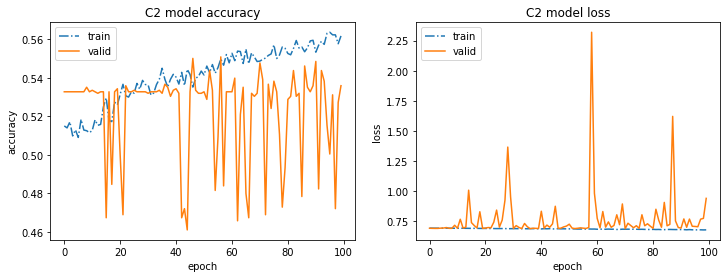

In [130]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_c2.history['accuracy'],linestyle='-.')
plt.plot(history_c2.history['val_accuracy'])
plt.title('C2 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.subplot(1,2,(2))
plt.plot(history_c2.history['loss'],linestyle='-.')
plt.plot(history_c2.history['val_loss'])
plt.title('C2 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [131]:
# evaluate the model
_, train_acc_c2 = model_c2.evaluate(X_train, Y_train, verbose=0)
_, val_acc_c2   = model_c2.evaluate(X_val, Y_val, verbose=0)
_, test_acc_c2  = model_c2.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_c2, val_acc_c2, test_acc_c2))

Train: 0.5135, Val: 0.5359, Test: 0.5424


In [132]:
res_c2 = pd.DataFrame(
          {'ID': 'C2',
           'Type': 'LSTM',
           'Timesteps': n_steps_set1,
           'Train Acc': train_acc_c2,
           'Val Acc': val_acc_c2,
           'Test Acc': test_acc_c2}, index=['C2: LSTM - scaled - 8 timesteps - tuned'])

pd.concat([res_a1,res_a2,res_a3,res_a4,res_a5,res_a6,res_b1,res_b2,res_b3,res_c1,res_c2])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234
A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned,A3,1D CNN,8,0.73894900,0.50828731,0.51385587
A4: 1D CNN - scaled - without dilation - 16 timesteps - tuned v1,A4,1D CNN,16,0.92952186,0.49960536,0.51429707
A5: 1D CNN - scaled - without dilation - 16 timesteps - tuned v2,A5,1D CNN,16,0.98353630,0.51775849,0.48332009
A6: 1D CNN - scaled - with dilation - 16 timesteps - tuned,A6,1D CNN,16,0.96053225,0.49486977,0.51191419
B1: fcNN - scaled - 8 timesteps,B1,fcNN,8,0.65820926,0.49802685,0.50395882
B2: fcNN - scaled - 8 timesteps - with dropout,B2,fcNN,8,0.55615699,0.50276244,0.50118762
B3: fcNN - scaled - 16 timesteps,B3,fcNN,16,0.64253497,0.49171272,0.48610008
C1: LSTM - non-scaled - 8 timesteps - one LSTM layer,C1,LSTM,8,0.52210194,0.50828731,0.51781476


### C3) LSTM - scaled - 16 timesteps - tuned

In [133]:
model_c3 = Sequential()

model_c3.add(LSTM(25, return_sequences=True, input_shape=(n_steps_set2,1)))
model_c3.add(BatchNormalization())
model_c3.add(Activation('relu'))

model_c3.add(LSTM(50))
model_c3.add(BatchNormalization())
model_c3.add(Activation('relu'))
model_c3.add(Dropout(0.2))

model_c3.add(Dense(100, activation='relu'))
model_c3.add(Dropout(0.3))
model_c3.add(Dense(50, activation='relu'))
model_c3.add(Dropout(0.2))

model_c3.add(Dense(1, activation='sigmoid'))
model_c3.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model_c3.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 16, 25)            2700      
_________________________________________________________________
batch_normalization_42 (Batc (None, 16, 25)            100       
_________________________________________________________________
activation_34 (Activation)   (None, 16, 25)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                15200     
_________________________________________________________________
batch_normalization_43 (Batc (None, 50)                200       
_________________________________________________________________
activation_35 (Activation)   (None, 50)                0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 50)              

In [134]:
# define the input & target dataset
# check that we're using the right input set
X = X_logret_set2_scaled
Y = Y_sign_set2
n_steps_set2, X[0:1], Y[0:1]

(16, array([[[0.71644023],
         [0.6830203 ],
         [0.7028579 ],
         [0.71013183],
         [0.69553951],
         [0.68279487],
         [0.70043513],
         [0.70624829],
         [0.70177252],
         [0.70062114],
         [0.6860502 ],
         [0.710541  ],
         [0.71981492],
         [0.71766553],
         [0.66708769],
         [0.68055014]]]), array([[[0.]]]))

In [135]:
# split data into train, val and test
X_train = X[0:train_id]
Y_train = Y[0:train_id]
X_val   = X[train_id:val_id]
Y_val   = Y[train_id:val_id]
X_test  = X[val_id:]
Y_test  = Y[val_id:]
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(8868, 16, 1) (8868, 1, 1)
(1267, 16, 1) (1267, 1, 1)
(2518, 16, 1) (2518, 1, 1)


In [136]:
history_c3 = model_c3.fit(X_train, Y_train,
                          epochs=100,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/100
70/70 [==============================] - 1s 21ms/step - loss: 0.6935 - accuracy: 0.5007 - val_loss: 0.6915 - val_accuracy: 0.5351
Epoch 2/100
70/70 [==============================] - 1s 12ms/step - loss: 0.6934 - accuracy: 0.5063 - val_loss: 0.6910 - val_accuracy: 0.5351
Epoch 3/100
70/70 [==============================] - 1s 12ms/step - loss: 0.6927 - accuracy: 0.5193 - val_loss: 0.6916 - val_accuracy: 0.5351
Epoch 4/100
70/70 [==============================] - 1s 12ms/step - loss: 0.6928 - accuracy: 0.5104 - val_loss: 0.6911 - val_accuracy: 0.5351
Epoch 5/100
70/70 [==============================] - 1s 11ms/step - loss: 0.6929 - accuracy: 0.5161 - val_loss: 0.6906 - val_accuracy: 0.5351
Epoch 6/100
70/70 [==============================] - 1s 11ms/step - loss: 0.6928 - accuracy: 0.5123 - val_loss: 0.6915 - val_accuracy: 0.5351
Epoch 7/100
70/70 [==============================] - 1s 11ms/step - loss: 0.6924 - accuracy: 0.5150 - val_loss: 0.6915 - val_accuracy: 0.5351
Epoch 

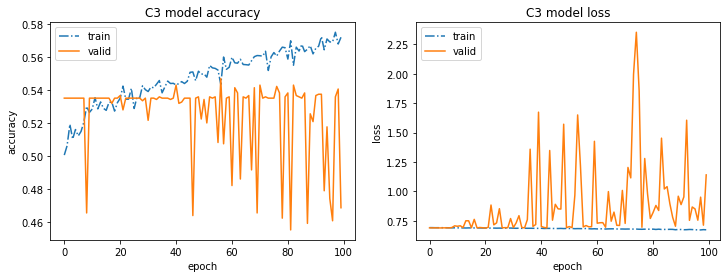

In [137]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_c3.history['accuracy'],linestyle='-.')
plt.plot(history_c3.history['val_accuracy'])
plt.title('C3 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.subplot(1,2,(2))
plt.plot(history_c3.history['loss'],linestyle='-.')
plt.plot(history_c3.history['val_loss'])
plt.title('C3 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [138]:
# evaluate the model
_, train_acc_c3 = model_c3.evaluate(X_train, Y_train, verbose=0)
_, val_acc_c3   = model_c3.evaluate(X_val, Y_val, verbose=0)
_, test_acc_c3  = model_c3.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_c3, val_acc_c3, test_acc_c3))

Train: 0.4980, Val: 0.4688, Test: 0.4603


In [139]:
res_c3 = pd.DataFrame(
          {'ID': 'C3',
           'Type': 'LSTM',
           'Timesteps': n_steps_set2,
           'Train Acc': train_acc_c3,
           'Val Acc': val_acc_c3,
           'Test Acc': test_acc_c3}, index=['C3: LSTM - scaled - 16 timesteps - tuned'])

pd.concat([res_a1,res_a2,res_a3,res_a4,res_a5,res_a6,res_b1,res_b2,res_b3,res_c1,res_c2,res_c3])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234
A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned,A3,1D CNN,8,0.73894900,0.50828731,0.51385587
A4: 1D CNN - scaled - without dilation - 16 timesteps - tuned v1,A4,1D CNN,16,0.92952186,0.49960536,0.51429707
A5: 1D CNN - scaled - without dilation - 16 timesteps - tuned v2,A5,1D CNN,16,0.98353630,0.51775849,0.48332009
A6: 1D CNN - scaled - with dilation - 16 timesteps - tuned,A6,1D CNN,16,0.96053225,0.49486977,0.51191419
B1: fcNN - scaled - 8 timesteps,B1,fcNN,8,0.65820926,0.49802685,0.50395882
B2: fcNN - scaled - 8 timesteps - with dropout,B2,fcNN,8,0.55615699,0.50276244,0.50118762
B3: fcNN - scaled - 16 timesteps,B3,fcNN,16,0.64253497,0.49171272,0.48610008
C1: LSTM - non-scaled - 8 timesteps - one LSTM layer,C1,LSTM,8,0.52210194,0.50828731,0.51781476


### C4) LSTM - scaled - 40 timesteps - tuned

### Split data for set3 -> timesteps = 40

In [0]:
# choose number of days for input data set (e.g. 8 previous days will used to predict the next day's value)
n_steps_set3 = 40
# set number of features (in our case 1)
n_features = 1

In [0]:
# split data into input (log_return) and target (sign of log_return = up or down = 1 or 0)
X_logret_set3, Y_sign_set3 = split_sequence(raw_seq_log_return, n_steps_set3, sign=True)

In [142]:
# check shape of the data, final shape needs to have 3 dimensions
print(X_logret_set3.shape)
print(Y_sign_set3.shape)

(12629, 40)
(12629,)


In [143]:
# add scaled X using MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X_logret_set3_scaled = sc.fit_transform(X_logret_set3)
# and check the shape again and some values
print(X_logret_set3_scaled.shape)
print(X_logret_set3_scaled[0:2])
print(X_logret_set3[0:2])

(12629, 40)
[[0.71644023 0.6830203  0.7028579  0.71013183 0.69553951 0.68279487
  0.70043513 0.70624829 0.70177252 0.70062114 0.6860502  0.71557371
  0.72491332 0.72274871 0.67181263 0.68537043 0.69158064 0.69051958
  0.67071748 0.69332703 0.71807128 0.74978642 0.69836387 0.69367814
  0.71847628 0.71991041 0.67589728 0.74860724 0.70294321 0.70076268
  0.71070366 0.68611983 0.74370689 0.71332657 0.70755497 0.69319725
  0.7542656  0.69051535 0.7510722  0.71355877]
 [0.6830203  0.7028579  0.71013183 0.69553951 0.68279487 0.70043513
  0.70624829 0.70177252 0.70062114 0.6860502  0.71557371 0.72491332
  0.72274871 0.67181263 0.68537043 0.69158064 0.69051958 0.67071748
  0.69332703 0.71807128 0.74978642 0.69836387 0.69367814 0.71847628
  0.71991041 0.67589728 0.74860724 0.70294321 0.70076268 0.71070366
  0.68611983 0.74370689 0.71332657 0.70755497 0.69810712 0.7542656
  0.69051535 0.7510722  0.71355877 0.72944978]]
[[ 0.0026041  -0.00947396 -0.00230459  0.00032423 -0.00494948 -0.00955543
  -0

In [144]:
# reshape to fit the final form for input to the NN's
# X from [samples, timesteps] into [samples, timesteps, features]
X_logret_set3 = X_logret_set3.reshape((X_logret_set3.shape[0], X_logret_set3.shape[1], n_features))
X_logret_set3_scaled = X_logret_set3_scaled.reshape((X_logret_set3_scaled.shape[0], X_logret_set3_scaled.shape[1], n_features))
# Y from [samples] into [samples, timesteps, features]
Y_sign_set3 = Y_sign_set3.reshape((len(Y_sign_set3),1))
Y_sign_set3 = Y_sign_set3.reshape((Y_sign_set3.shape[0], Y_sign_set3.shape[1], n_features))
print(X_logret_set3.shape)
print(X_logret_set3_scaled.shape)
print(Y_sign_set3.shape)

(12629, 40, 1)
(12629, 40, 1)
(12629, 1, 1)


In [145]:
model_c4 = Sequential()

model_c4.add(LSTM(25, return_sequences=True, input_shape=(n_steps_set3,1)))
model_c4.add(BatchNormalization())
model_c4.add(Activation('relu'))

model_c4.add(LSTM(50))
model_c4.add(BatchNormalization())
model_c4.add(Activation('relu'))
model_c4.add(Dropout(0.2))

model_c4.add(Dense(100, activation='relu'))
model_c4.add(Dropout(0.3))
model_c4.add(Dense(50, activation='relu'))
model_c4.add(Dropout(0.2))

model_c4.add(Dense(1, activation='sigmoid'))
model_c4.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model_c4.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 40, 25)            2700      
_________________________________________________________________
batch_normalization_44 (Batc (None, 40, 25)            100       
_________________________________________________________________
activation_36 (Activation)   (None, 40, 25)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                15200     
_________________________________________________________________
batch_normalization_45 (Batc (None, 50)                200       
_________________________________________________________________
activation_37 (Activation)   (None, 50)                0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 50)              

In [146]:
# define the input & target dataset
# check that we're using the right input set
X = X_logret_set3_scaled
Y = Y_sign_set3
n_steps_set3, X[0:1], Y[0:1]

(40, array([[[0.71644023],
         [0.6830203 ],
         [0.7028579 ],
         [0.71013183],
         [0.69553951],
         [0.68279487],
         [0.70043513],
         [0.70624829],
         [0.70177252],
         [0.70062114],
         [0.6860502 ],
         [0.71557371],
         [0.72491332],
         [0.72274871],
         [0.67181263],
         [0.68537043],
         [0.69158064],
         [0.69051958],
         [0.67071748],
         [0.69332703],
         [0.71807128],
         [0.74978642],
         [0.69836387],
         [0.69367814],
         [0.71847628],
         [0.71991041],
         [0.67589728],
         [0.74860724],
         [0.70294321],
         [0.70076268],
         [0.71070366],
         [0.68611983],
         [0.74370689],
         [0.71332657],
         [0.70755497],
         [0.69319725],
         [0.7542656 ],
         [0.69051535],
         [0.7510722 ],
         [0.71355877]]]), array([[[1.]]]))

In [147]:
# split data into train, val and test
X_train = X[0:train_id]
Y_train = Y[0:train_id]
X_val   = X[train_id:val_id]
Y_val   = Y[train_id:val_id]
X_test  = X[val_id:]
Y_test  = Y[val_id:]
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(8868, 40, 1) (8868, 1, 1)
(1267, 40, 1) (1267, 1, 1)
(2494, 40, 1) (2494, 1, 1)


In [148]:
history_c4 = model_c4.fit(X_train, Y_train,
                          epochs=100,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/100
70/70 [==============================] - 2s 23ms/step - loss: 0.6939 - accuracy: 0.5043 - val_loss: 0.6920 - val_accuracy: 0.5422
Epoch 2/100
70/70 [==============================] - 1s 14ms/step - loss: 0.6935 - accuracy: 0.5038 - val_loss: 0.6919 - val_accuracy: 0.5422
Epoch 3/100
70/70 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5087 - val_loss: 0.6923 - val_accuracy: 0.5422
Epoch 4/100
70/70 [==============================] - 1s 13ms/step - loss: 0.6927 - accuracy: 0.5114 - val_loss: 0.6913 - val_accuracy: 0.5422
Epoch 5/100
70/70 [==============================] - 1s 13ms/step - loss: 0.6929 - accuracy: 0.5090 - val_loss: 0.6903 - val_accuracy: 0.5422
Epoch 6/100
70/70 [==============================] - 1s 14ms/step - loss: 0.6922 - accuracy: 0.5130 - val_loss: 0.6898 - val_accuracy: 0.5422
Epoch 7/100
70/70 [==============================] - 1s 14ms/step - loss: 0.6924 - accuracy: 0.5191 - val_loss: 0.6898 - val_accuracy: 0.5422
Epoch 

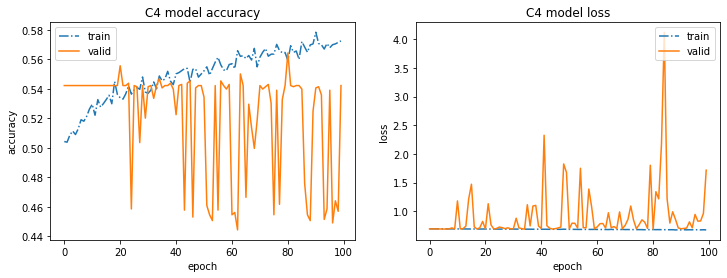

In [149]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_c4.history['accuracy'],linestyle='-.')
plt.plot(history_c4.history['val_accuracy'])
plt.title('C4 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.subplot(1,2,(2))
plt.plot(history_c4.history['loss'],linestyle='-.')
plt.plot(history_c4.history['val_loss'])
plt.title('C4 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [150]:
# evaluate the model
_, train_acc_c4 = model_c4.evaluate(X_train, Y_train, verbose=0)
_, val_acc_c4   = model_c4.evaluate(X_val, Y_val, verbose=0)
_, test_acc_c4  = model_c4.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_c4, val_acc_c4, test_acc_c4))

Train: 0.5136, Val: 0.5422, Test: 0.5385


In [151]:
res_c4 = pd.DataFrame(
          {'ID': 'C4',
           'Type': 'LSTM',
           'Timesteps': n_steps_set3,
           'Train Acc': train_acc_c4,
           'Val Acc': val_acc_c4,
           'Test Acc': test_acc_c4}, index=['C4: LSTM - scaled - 40 timesteps - tuned'])

pd.concat([res_a1,res_a2,res_a3,res_a4,res_a5,res_a6,res_b1,res_b2,res_b3,res_c1,res_c2,res_c3,res_c4])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234
A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned,A3,1D CNN,8,0.73894900,0.50828731,0.51385587
A4: 1D CNN - scaled - without dilation - 16 timesteps - tuned v1,A4,1D CNN,16,0.92952186,0.49960536,0.51429707
A5: 1D CNN - scaled - without dilation - 16 timesteps - tuned v2,A5,1D CNN,16,0.98353630,0.51775849,0.48332009
A6: 1D CNN - scaled - with dilation - 16 timesteps - tuned,A6,1D CNN,16,0.96053225,0.49486977,0.51191419
B1: fcNN - scaled - 8 timesteps,B1,fcNN,8,0.65820926,0.49802685,0.50395882
B2: fcNN - scaled - 8 timesteps - with dropout,B2,fcNN,8,0.55615699,0.50276244,0.50118762
B3: fcNN - scaled - 16 timesteps,B3,fcNN,16,0.64253497,0.49171272,0.48610008
C1: LSTM - non-scaled - 8 timesteps - one LSTM layer,C1,LSTM,8,0.52210194,0.50828731,0.51781476


***
# 7. SECTION D: 2D CNN

### D1) 2D CNN - linechart - 8 timesteps - 32x32 pixel - v1 simple

In [0]:
#pix = 32
# load image data
X_dji_8_32 = np.load('/content/X_dji_8_32x32.npy')
Y_dji_8_32 = np.load('/content/Y_dji_8_32x32.npy')

In [0]:
# normalize inputs from 0-255 to 0-1
X_dji_8_32 /= 255

# one-hot encode label
number_of_classes = 2
Y_dji_8_32 = to_categorical(Y_dji_8_32, number_of_classes)

In [154]:
# split into train, validation and test
X_train = X_dji_8_32[0:train_id]
Y_train = Y_dji_8_32[0:train_id]

X_val = X_dji_8_32[train_id:val_id]
Y_val = Y_dji_8_32[train_id:val_id]

X_test = X_dji_8_32[val_id:]
Y_test = Y_dji_8_32[val_id:]

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(8868, 32, 32, 1) (8868, 2)
(1267, 32, 32, 1) (1267, 2)
(2526, 32, 32, 1) (2526, 2)


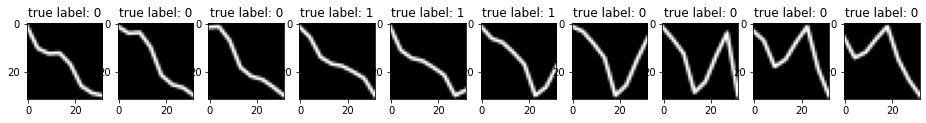

In [155]:
# visualize the 4 first linechart images 
plt.figure(figsize=(16,12))
for i in range(0,10):
    plt.subplot(1,10,(i+1))
    plt.imshow((X_train[i,:,:,0]),cmap="gray")
    plt.title('true label: '+np.str(np.argmax(Y_train,axis=1)[i]))
    #plt.axis('off')

In [0]:
# define hyperparameter of the CNN
batch_size = 128
nb_classes = 2
img_rows, img_cols = 32, 32
ks = (3, 3)
input_shape = (img_rows, img_cols, 1)
pool_size = (2, 2)

In [157]:
model_d1 = Sequential()

model_d1.add(Convolution2D(filters=8, kernel_size=ks, activation='relu', padding='same', input_shape=input_shape))
model_d1.add(Convolution2D(filters=8, kernel_size=ks, activation='relu', padding='same'))
model_d1.add(MaxPooling2D(pool_size=pool_size))

model_d1.add(Convolution2D(16, kernel_size=ks, activation='relu', padding='same'))
model_d1.add(Convolution2D(16, kernel_size=ks, activation='relu', padding='same'))
model_d1.add(MaxPooling2D(pool_size=pool_size))

model_d1.add(Flatten())
model_d1.add(Dense(40, activation='relu'))
model_d1.add(Dense(nb_classes))
model_d1.add(Activation('softmax'))

model_d1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_d1.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1024)            

In [158]:
history_d1 = model_d1.fit(X_train, Y_train,
                          epochs=20,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/20
70/70 [==============================] - 1s 10ms/step - loss: 0.6928 - accuracy: 0.5124 - val_loss: 0.6933 - val_accuracy: 0.5091
Epoch 2/20
70/70 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.5280 - val_loss: 0.6954 - val_accuracy: 0.4846
Epoch 3/20
70/70 [==============================] - 0s 5ms/step - loss: 0.6886 - accuracy: 0.5352 - val_loss: 0.6958 - val_accuracy: 0.4909
Epoch 4/20
70/70 [==============================] - 0s 5ms/step - loss: 0.6864 - accuracy: 0.5475 - val_loss: 0.6972 - val_accuracy: 0.5130
Epoch 5/20
70/70 [==============================] - 0s 5ms/step - loss: 0.6822 - accuracy: 0.5568 - val_loss: 0.7012 - val_accuracy: 0.5012
Epoch 6/20
70/70 [==============================] - 0s 6ms/step - loss: 0.6786 - accuracy: 0.5698 - val_loss: 0.7050 - val_accuracy: 0.5249
Epoch 7/20
70/70 [==============================] - 0s 5ms/step - loss: 0.6699 - accuracy: 0.5903 - val_loss: 0.7116 - val_accuracy: 0.5083
Epoch 8/20
70/70 [=

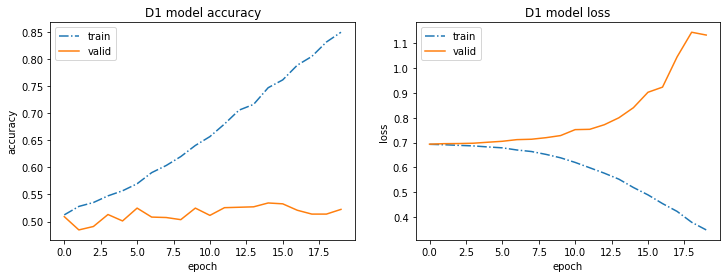

In [159]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_d1.history['accuracy'],linestyle='-.')
plt.plot(history_d1.history['val_accuracy'])
plt.title('D1 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.subplot(1,2,(2))
plt.plot(history_d1.history['loss'],linestyle='-.')
plt.plot(history_d1.history['val_loss'])
plt.title('D1 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

In [160]:
# evaluate the model
_, train_acc_d1 = model_d1.evaluate(X_train, Y_train, verbose=0)
_, val_acc_d1   = model_d1.evaluate(X_val, Y_val, verbose=0)
_, test_acc_d1  = model_d1.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_d1, val_acc_d1, test_acc_d1))

Train: 0.8957, Val: 0.5225, Test: 0.5099


In [161]:
res_d1 = pd.DataFrame(
          {'ID': 'D1',
           'Type': '2D CNN',
           'Timesteps': 8,
           'Train Acc': train_acc_d1,
           'Val Acc': val_acc_d1,
           'Test Acc': test_acc_d1}, index=['D1: 2D CNN - linechart - 8 timesteps - 32x32 pixel - simple'])

pd.concat([res_a1,res_a2,res_a3,res_a4,res_a5,res_a6,
           res_b1,res_b2,res_b3,
           res_c1,res_c2,res_c3,res_c4,
           res_d1])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234
A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned,A3,1D CNN,8,0.73894900,0.50828731,0.51385587
A4: 1D CNN - scaled - without dilation - 16 timesteps - tuned v1,A4,1D CNN,16,0.92952186,0.49960536,0.51429707
A5: 1D CNN - scaled - without dilation - 16 timesteps - tuned v2,A5,1D CNN,16,0.98353630,0.51775849,0.48332009
A6: 1D CNN - scaled - with dilation - 16 timesteps - tuned,A6,1D CNN,16,0.96053225,0.49486977,0.51191419
B1: fcNN - scaled - 8 timesteps,B1,fcNN,8,0.65820926,0.49802685,0.50395882
B2: fcNN - scaled - 8 timesteps - with dropout,B2,fcNN,8,0.55615699,0.50276244,0.50118762
B3: fcNN - scaled - 16 timesteps,B3,fcNN,16,0.64253497,0.49171272,0.48610008
C1: LSTM - non-scaled - 8 timesteps - one LSTM layer,C1,LSTM,8,0.52210194,0.50828731,0.51781476


### D2) 2D CNN - linechart - 8 timesteps - 32x32 pixel - v2 deeper

In [0]:
# define hyperparameter of the CNN
batch_size = 128
nb_classes = 2
img_rows, img_cols = 32, 32
ks = (3, 3)
input_shape = (img_rows, img_cols, 1)
pool_size = (2, 2)

In [163]:
model_d2 = Sequential()

model_d2.add(Convolution2D(filters=16, kernel_size=ks, activation='relu', padding='same', input_shape=input_shape))
model_d2.add(Convolution2D(filters=16, kernel_size=ks, activation='relu', padding='same'))
model_d2.add(MaxPooling2D(pool_size=pool_size))

model_d2.add(Convolution2D(32, kernel_size=ks, activation='relu', padding='same'))
model_d2.add(Convolution2D(32, kernel_size=ks, activation='relu', padding='same'))
model_d2.add(MaxPooling2D(pool_size=pool_size))

model_d2.add(Flatten())
model_d2.add(Dense(128, activation='relu'))
model_d2.add(Dense(nb_classes))
model_d2.add(Activation('softmax'))

# compile model and intitialize weights
model_d2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# summarize model along with number of model weights
model_d2.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)            

In [164]:
history_d2 = model_d2.fit(X_train, Y_train,
                          epochs=20,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 0.6929 - accuracy: 0.5159 - val_loss: 0.6932 - val_accuracy: 0.5257
Epoch 2/20
70/70 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5280 - val_loss: 0.6938 - val_accuracy: 0.5225
Epoch 3/20
70/70 [==============================] - 0s 7ms/step - loss: 0.6902 - accuracy: 0.5268 - val_loss: 0.6971 - val_accuracy: 0.4933
Epoch 4/20
70/70 [==============================] - 0s 7ms/step - loss: 0.6878 - accuracy: 0.5462 - val_loss: 0.7015 - val_accuracy: 0.4964
Epoch 5/20
70/70 [==============================] - 0s 7ms/step - loss: 0.6846 - accuracy: 0.5507 - val_loss: 0.6984 - val_accuracy: 0.4783
Epoch 6/20
70/70 [==============================] - 0s 7ms/step - loss: 0.6807 - accuracy: 0.5666 - val_loss: 0.7159 - val_accuracy: 0.4775
Epoch 7/20
70/70 [==============================] - 0s 7ms/step - loss: 0.6721 - accuracy: 0.5841 - val_loss: 0.7104 - val_accuracy: 0.5059
Epoch 8/20
70/70 [=

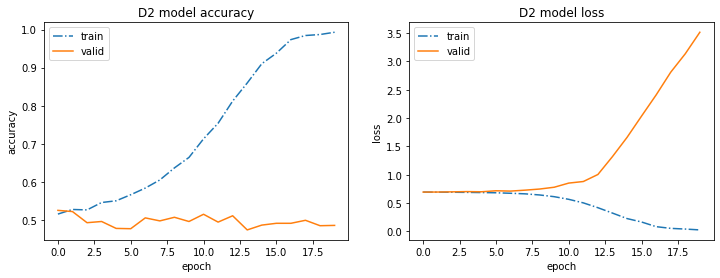

In [165]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_d2.history['accuracy'],linestyle='-.')
plt.plot(history_d2.history['val_accuracy'])
plt.title('D2 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.subplot(1,2,(2))
plt.plot(history_d2.history['loss'],linestyle='-.')
plt.plot(history_d2.history['val_loss'])
plt.title('D2 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

In [166]:
# evaluate the model
_, train_acc_d2 = model_d2.evaluate(X_train, Y_train, verbose=0)
_, val_acc_d2   = model_d2.evaluate(X_val, Y_val, verbose=0)
_, test_acc_d2  = model_d2.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_d2, val_acc_d2, test_acc_d2))

Train: 0.9945, Val: 0.4862, Test: 0.5063


In [167]:
res_d2 = pd.DataFrame(
          {'ID': 'D2',
           'Type': '2D CNN',
           'Timesteps': 8,
           'Train Acc': train_acc_d2,
           'Val Acc': val_acc_d2,
           'Test Acc': test_acc_d2}, index=['D2: 2D CNN - linechart - 8 timesteps - 32x32 pixel - deeper'])

pd.concat([res_a1,res_a2,res_a3,res_a4,res_a5,res_a6,
           res_b1,res_b2,res_b3,
           res_c1,res_c2,res_c3,res_c4,
           res_d1,res_d2])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234
A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned,A3,1D CNN,8,0.73894900,0.50828731,0.51385587
A4: 1D CNN - scaled - without dilation - 16 timesteps - tuned v1,A4,1D CNN,16,0.92952186,0.49960536,0.51429707
A5: 1D CNN - scaled - without dilation - 16 timesteps - tuned v2,A5,1D CNN,16,0.98353630,0.51775849,0.48332009
A6: 1D CNN - scaled - with dilation - 16 timesteps - tuned,A6,1D CNN,16,0.96053225,0.49486977,0.51191419
B1: fcNN - scaled - 8 timesteps,B1,fcNN,8,0.65820926,0.49802685,0.50395882
B2: fcNN - scaled - 8 timesteps - with dropout,B2,fcNN,8,0.55615699,0.50276244,0.50118762
B3: fcNN - scaled - 16 timesteps,B3,fcNN,16,0.64253497,0.49171272,0.48610008
C1: LSTM - non-scaled - 8 timesteps - one LSTM layer,C1,LSTM,8,0.52210194,0.50828731,0.51781476


### D3) 2D CNN - linechart - 8 timesteps - 32x32 pixel - v3 with dropout

In [0]:
# define hyperparameter of the CNN
batch_size = 128
nb_classes = 2
img_rows, img_cols = 32, 32
ks = (3, 3)
input_shape = (img_rows, img_cols, 1)
pool_size = (2, 2)

In [169]:
model_d3 = Sequential()

model_d3.add(Convolution2D(filters=16, kernel_size=ks, activation='relu', padding='same', input_shape=input_shape))
model_d3.add(Convolution2D(filters=16, kernel_size=ks, activation='relu', padding='same'))
model_d3.add(MaxPooling2D(pool_size=pool_size))

model_d3.add(Convolution2D(32, kernel_size=ks, activation='relu', padding='same'))
model_d3.add(Convolution2D(32, kernel_size=ks, activation='relu', padding='same'))
model_d3.add(MaxPooling2D(pool_size=pool_size))

model_d3.add(Flatten())
model_d3.add(Dropout(0.3))
model_d3.add(Dense(500, activation='relu'))
model_d3.add(Dropout(0.3))
model_d3.add(Dense(300, activation='relu'))
model_d3.add(Dropout(0.3))
model_d3.add(Dense(100, activation='relu'))

model_d3.add(Dense(nb_classes))
model_d3.add(Activation('softmax'))

model_d3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_d3.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 16)        160       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)            

In [170]:
# train the model
history_d3 = model_d3.fit(X_train, Y_train,
                          epochs=20,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/20
70/70 [==============================] - 1s 10ms/step - loss: 0.6935 - accuracy: 0.5112 - val_loss: 0.6914 - val_accuracy: 0.5328
Epoch 2/20
70/70 [==============================] - 1s 7ms/step - loss: 0.6924 - accuracy: 0.5105 - val_loss: 0.6916 - val_accuracy: 0.5328
Epoch 3/20
70/70 [==============================] - 1s 7ms/step - loss: 0.6930 - accuracy: 0.5126 - val_loss: 0.6924 - val_accuracy: 0.5312
Epoch 4/20
70/70 [==============================] - 1s 7ms/step - loss: 0.6923 - accuracy: 0.5174 - val_loss: 0.6928 - val_accuracy: 0.5312
Epoch 5/20
70/70 [==============================] - 0s 7ms/step - loss: 0.6920 - accuracy: 0.5154 - val_loss: 0.6971 - val_accuracy: 0.4949
Epoch 6/20
70/70 [==============================] - 1s 8ms/step - loss: 0.6905 - accuracy: 0.5291 - val_loss: 0.6969 - val_accuracy: 0.5264
Epoch 7/20
70/70 [==============================] - 1s 7ms/step - loss: 0.6899 - accuracy: 0.5354 - val_loss: 0.6944 - val_accuracy: 0.5051
Epoch 8/20
70/70 [=

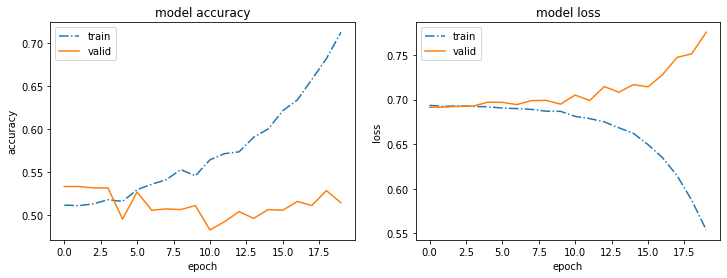

In [171]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_d3.history['accuracy'],linestyle='-.')
plt.plot(history_d3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.subplot(1,2,(2))
plt.plot(history_d3.history['loss'],linestyle='-.')
plt.plot(history_d3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

In [172]:
# evaluate the model
_, train_acc_d3 = model_d3.evaluate(X_train, Y_train, verbose=0)
_, val_acc_d3   = model_d3.evaluate(X_val, Y_val, verbose=0)
_, test_acc_d3  = model_d3.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_d3, val_acc_d3, test_acc_d3))

Train: 0.8251, Val: 0.5138, Test: 0.4988


In [173]:
res_d3 = pd.DataFrame(
          {'ID': 'D3',
           'Type': '2D CNN',
           'Timesteps': 8,
           'Train Acc': train_acc_d3,
           'Val Acc': val_acc_d3,
           'Test Acc': test_acc_d3}, index=['D3: 2D CNN - linechart - 8 timesteps - 32x32 pixel - with dropout'])

pd.concat([res_a1,res_a2,res_a3,res_a4,res_a5,res_a6,
           res_b1,res_b2,res_b3,
           res_c1,res_c2,res_c3,res_c4,
           res_d1,res_d2,res_d3])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234
A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned,A3,1D CNN,8,0.73894900,0.50828731,0.51385587
A4: 1D CNN - scaled - without dilation - 16 timesteps - tuned v1,A4,1D CNN,16,0.92952186,0.49960536,0.51429707
A5: 1D CNN - scaled - without dilation - 16 timesteps - tuned v2,A5,1D CNN,16,0.98353630,0.51775849,0.48332009
A6: 1D CNN - scaled - with dilation - 16 timesteps - tuned,A6,1D CNN,16,0.96053225,0.49486977,0.51191419
B1: fcNN - scaled - 8 timesteps,B1,fcNN,8,0.65820926,0.49802685,0.50395882
B2: fcNN - scaled - 8 timesteps - with dropout,B2,fcNN,8,0.55615699,0.50276244,0.50118762
B3: fcNN - scaled - 16 timesteps,B3,fcNN,16,0.64253497,0.49171272,0.48610008
C1: LSTM - non-scaled - 8 timesteps - one LSTM layer,C1,LSTM,8,0.52210194,0.50828731,0.51781476


### D4) 2D CNN - linechart - 8 timesteps - 32x32 pixel - with batchnorm

In [0]:
# load image data and don't normalize with 255
X_dji_8_32 = np.load('/content/X_dji_8_32x32.npy')
Y_dji_8_32 = np.load('/content/Y_dji_8_32x32.npy')

In [0]:
# one-hot encode label
number_of_classes = 2
Y_dji_8_32 = to_categorical(Y_dji_8_32, number_of_classes)

In [176]:
# split into train, validation and test
X_train = X_dji_8_32[0:train_id]
Y_train = Y_dji_8_32[0:train_id]

X_val = X_dji_8_32[train_id:val_id]
Y_val = Y_dji_8_32[train_id:val_id]

X_test = X_dji_8_32[val_id:]
Y_test = Y_dji_8_32[val_id:]

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(8868, 32, 32, 1) (8868, 2)
(1267, 32, 32, 1) (1267, 2)
(2526, 32, 32, 1) (2526, 2)


In [0]:
# define hyperparameter of the CNN
batch_size = 128
nb_classes = 2
img_rows, img_cols = 32, 32
ks = (3, 3)
input_shape = (img_rows, img_cols, 1)
pool_size = (2, 2)

In [178]:
model_d4 = Sequential()

model_d4.add(BatchNormalization(input_shape=input_shape))

model_d4.add(Convolution2D(filters=16, kernel_size=ks, padding='same'))
model_d4.add(BatchNormalization())
model_d4.add(Activation('relu'))
model_d4.add(Convolution2D(filters=16, kernel_size=ks, padding='same'))
model_d4.add(BatchNormalization())
model_d4.add(Activation('relu'))
model_d4.add(MaxPooling2D(pool_size=pool_size))

model_d4.add(Convolution2D(filters=32, kernel_size=ks, padding='same'))
model_d4.add(BatchNormalization())
model_d4.add(Activation('relu'))
model_d4.add(Convolution2D(filters=32, kernel_size=ks, padding='same'))
model_d4.add(BatchNormalization())
model_d4.add(Activation('relu'))
model_d4.add(MaxPooling2D(pool_size=pool_size))

model_d4.add(Flatten())
#model_d3.add(Dropout(0.3))
model_d4.add(Dense(500, activation='relu'))
#model_d3.add(Dropout(0.3))
model_d4.add(Dense(300, activation='relu'))
#model_d3.add(Dropout(0.3))
model_d4.add(Dense(100, activation='relu'))

model_d4.add(Dense(nb_classes))
model_d4.add(Activation('softmax'))

model_d4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_d4.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_46 (Batc (None, 32, 32, 1)         4         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 16)        160       
_________________________________________________________________
batch_normalization_47 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
activation_41 (Activation)   (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_48 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
activation_42 (Activation)   (None, 32, 32, 16)      

In [179]:
# train the model
history_d4 = model_d4.fit(X_train, Y_train,
                          epochs=20,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 0.7647 - accuracy: 0.5086 - val_loss: 0.6914 - val_accuracy: 0.5328
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 0.6940 - accuracy: 0.5184 - val_loss: 0.6991 - val_accuracy: 0.4594
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 0.6912 - accuracy: 0.5277 - val_loss: 0.6964 - val_accuracy: 0.4854
Epoch 4/20
70/70 [==============================] - 1s 9ms/step - loss: 0.6867 - accuracy: 0.5474 - val_loss: 0.7047 - val_accuracy: 0.4696
Epoch 5/20
70/70 [==============================] - 1s 9ms/step - loss: 0.6880 - accuracy: 0.5468 - val_loss: 0.7266 - val_accuracy: 0.4633
Epoch 6/20
70/70 [==============================] - 1s 9ms/step - loss: 0.6810 - accuracy: 0.5629 - val_loss: 0.7154 - val_accuracy: 0.5028
Epoch 7/20
70/70 [==============================] - 1s 9ms/step - loss: 0.6796 - accuracy: 0.5678 - val_loss: 0.7036 - val_accuracy: 0.4933
Epoch 8/20
70/70 [=

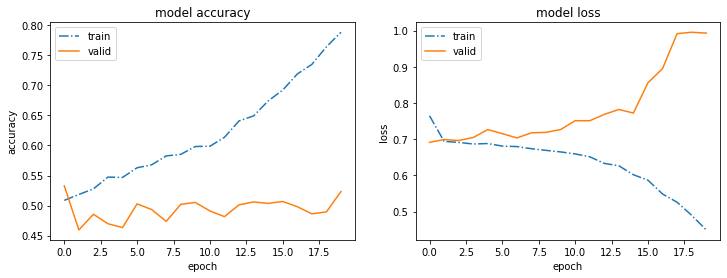

In [180]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_d4.history['accuracy'],linestyle='-.')
plt.plot(history_d4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.subplot(1,2,(2))
plt.plot(history_d4.history['loss'],linestyle='-.')
plt.plot(history_d4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

In [181]:
# evaluate the model
_, train_acc_d4 = model_d4.evaluate(X_train, Y_train, verbose=0)
_, val_acc_d4   = model_d4.evaluate(X_val, Y_val, verbose=0)
_, test_acc_d4  = model_d4.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_d4, val_acc_d4, test_acc_d4))

Train: 0.8191, Val: 0.5233, Test: 0.4988


In [182]:
res_d4 = pd.DataFrame(
          {'ID': 'D4',
           'Type': '2D CNN',
           'Timesteps': 8,
           'Train Acc': train_acc_d4,
           'Val Acc': val_acc_d4,
           'Test Acc': test_acc_d4}, index=['D4: 2D CNN - linechart - 8 timesteps - 32x32 pixel - with batchnorm'])

pd.concat([res_a1,res_a2,res_a3,res_a4,res_a5,res_a6,
           res_b1,res_b2,res_b3,
           res_c1,res_c2,res_c3,res_c4,
           res_d1,res_d2,res_d3,res_d4])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234
A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned,A3,1D CNN,8,0.73894900,0.50828731,0.51385587
A4: 1D CNN - scaled - without dilation - 16 timesteps - tuned v1,A4,1D CNN,16,0.92952186,0.49960536,0.51429707
A5: 1D CNN - scaled - without dilation - 16 timesteps - tuned v2,A5,1D CNN,16,0.98353630,0.51775849,0.48332009
A6: 1D CNN - scaled - with dilation - 16 timesteps - tuned,A6,1D CNN,16,0.96053225,0.49486977,0.51191419
B1: fcNN - scaled - 8 timesteps,B1,fcNN,8,0.65820926,0.49802685,0.50395882
B2: fcNN - scaled - 8 timesteps - with dropout,B2,fcNN,8,0.55615699,0.50276244,0.50118762
B3: fcNN - scaled - 16 timesteps,B3,fcNN,16,0.64253497,0.49171272,0.48610008
C1: LSTM - non-scaled - 8 timesteps - one LSTM layer,C1,LSTM,8,0.52210194,0.50828731,0.51781476


### D5) 2D CNN - linechart - 16 timesteps - 32x32 pixel - simple

In [0]:
X_dji_16_32 = np.load('/content/X_dji_16_32x32.npy')
Y_dji_16_32 = np.load('/content/Y_dji_16_32x32.npy')

In [0]:
# normalize inputs from 0-255 to 0-1
X_dji_16_32 /= 255

# one-hot encode label
number_of_classes = 2
Y_dji_16_32 = to_categorical(Y_dji_16_32, number_of_classes)

In [185]:
# split into train, validation and test
X_train = X_dji_16_32[0:train_id]
Y_train = Y_dji_16_32[0:train_id]

X_val = X_dji_16_32[train_id:val_id]
Y_val = Y_dji_16_32[train_id:val_id]

X_test = X_dji_16_32[val_id:]
Y_test = Y_dji_16_32[val_id:]

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(8868, 32, 32, 1) (8868, 2)
(1267, 32, 32, 1) (1267, 2)
(2518, 32, 32, 1) (2518, 2)


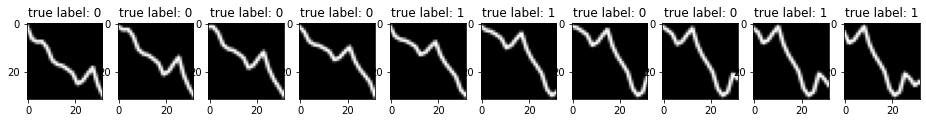

In [186]:
# visualize the 4 first linechart images 
plt.figure(figsize=(16,12))
for i in range(0,10):
    plt.subplot(1,10,(i+1))
    plt.imshow((X_train[i,:,:,0]),cmap="gray")
    plt.title('true label: '+np.str(np.argmax(Y_train,axis=1)[i]))
    #plt.axis('off')

In [0]:
# define hyperparameter of the CNN
batch_size = 128
nb_classes = 2
img_rows, img_cols = 32, 32
ks = (3, 3)
input_shape = (img_rows, img_cols, 1)
pool_size = (2, 2)

In [188]:
model_d5 = Sequential()

model_d5.add(Convolution2D(filters=8, kernel_size=ks, activation='relu', padding='same', input_shape=input_shape))
model_d5.add(Convolution2D(filters=8, kernel_size=ks, activation='relu', padding='same'))
model_d5.add(MaxPooling2D(pool_size=pool_size))

model_d5.add(Convolution2D(16, kernel_size=ks, activation='relu', padding='same'))
model_d5.add(Convolution2D(16, kernel_size=ks, activation='relu', padding='same'))
model_d5.add(MaxPooling2D(pool_size=pool_size))

model_d5.add(Flatten())
model_d5.add(Dense(40, activation='relu'))
model_d5.add(Dense(nb_classes))
model_d5.add(Activation('softmax'))

model_d5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_d5.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 8)         80        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 16)        1168      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1024)            

In [189]:
history_d5 = model_d5.fit(X_train, Y_train,
                          epochs=20,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/20
70/70 [==============================] - 1s 8ms/step - loss: 0.6934 - accuracy: 0.5109 - val_loss: 0.6922 - val_accuracy: 0.5185
Epoch 2/20
70/70 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5194 - val_loss: 0.6927 - val_accuracy: 0.5059
Epoch 3/20
70/70 [==============================] - 0s 6ms/step - loss: 0.6905 - accuracy: 0.5326 - val_loss: 0.6927 - val_accuracy: 0.5201
Epoch 4/20
70/70 [==============================] - 0s 5ms/step - loss: 0.6872 - accuracy: 0.5469 - val_loss: 0.6936 - val_accuracy: 0.5075
Epoch 5/20
70/70 [==============================] - 0s 5ms/step - loss: 0.6817 - accuracy: 0.5576 - val_loss: 0.7006 - val_accuracy: 0.4886
Epoch 6/20
70/70 [==============================] - 0s 5ms/step - loss: 0.6742 - accuracy: 0.5694 - val_loss: 0.7080 - val_accuracy: 0.4893
Epoch 7/20
70/70 [==============================] - 0s 6ms/step - loss: 0.6619 - accuracy: 0.5964 - val_loss: 0.7151 - val_accuracy: 0.4917
Epoch 8/20
70/70 [==

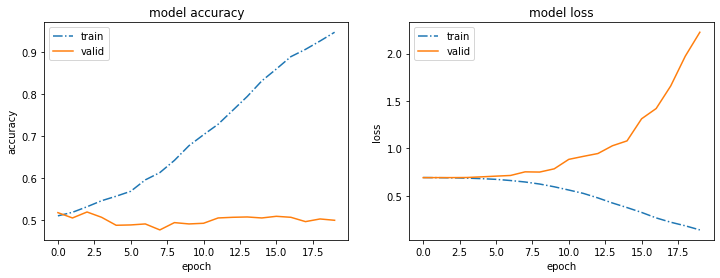

In [190]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_d5.history['accuracy'],linestyle='-.')
plt.plot(history_d5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.subplot(1,2,(2))
plt.plot(history_d5.history['loss'],linestyle='-.')
plt.plot(history_d5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

In [191]:
# evaluate the model
_, train_acc_d5 = model_d5.evaluate(X_train, Y_train, verbose=0)
_, val_acc_d5   = model_d5.evaluate(X_val, Y_val, verbose=0)
_, test_acc_d5  = model_d5.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_d5, val_acc_d5, test_acc_d5))

Train: 0.9763, Val: 0.5004, Test: 0.5171


In [192]:
res_d5 = pd.DataFrame(
          {'ID': 'D5',
           'Type': '2D CNN',
           'Timesteps': 16,
           'Train Acc': train_acc_d5,
           'Val Acc': val_acc_d5,
           'Test Acc': test_acc_d5}, index=['D5: 2D CNN - linechart - 16 timesteps - 32x32 pixel - simple'])

pd.concat([res_a1,res_a2,res_a3,res_a4,res_a5,res_a6,
           res_b1,res_b2,res_b3,
           res_c1,res_c2,res_c3,res_c4,
           res_d1,res_d2,res_d3,res_d4,res_d5])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234
A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned,A3,1D CNN,8,0.73894900,0.50828731,0.51385587
A4: 1D CNN - scaled - without dilation - 16 timesteps - tuned v1,A4,1D CNN,16,0.92952186,0.49960536,0.51429707
A5: 1D CNN - scaled - without dilation - 16 timesteps - tuned v2,A5,1D CNN,16,0.98353630,0.51775849,0.48332009
A6: 1D CNN - scaled - with dilation - 16 timesteps - tuned,A6,1D CNN,16,0.96053225,0.49486977,0.51191419
B1: fcNN - scaled - 8 timesteps,B1,fcNN,8,0.65820926,0.49802685,0.50395882
B2: fcNN - scaled - 8 timesteps - with dropout,B2,fcNN,8,0.55615699,0.50276244,0.50118762
B3: fcNN - scaled - 16 timesteps,B3,fcNN,16,0.64253497,0.49171272,0.48610008
C1: LSTM - non-scaled - 8 timesteps - one LSTM layer,C1,LSTM,8,0.52210194,0.50828731,0.51781476


### D6) 2D CNN - linechart - 16 timesteps - 32x32 pixel - deeper

In [0]:
# define hyperparameter of the CNN
batch_size = 128
nb_classes = 2
img_rows, img_cols = 32, 32
ks = (3, 3)
input_shape = (img_rows, img_cols, 1)
pool_size = (2, 2)

In [194]:
model_d6 = Sequential()

model_d6.add(Convolution2D(filters=16, kernel_size=ks, activation='relu', padding='same', input_shape=input_shape))
model_d6.add(Convolution2D(filters=16, kernel_size=ks, activation='relu', padding='same'))
model_d6.add(MaxPooling2D(pool_size=pool_size))

model_d6.add(Convolution2D(32, kernel_size=ks, activation='relu', padding='same'))
model_d6.add(Convolution2D(32, kernel_size=ks, activation='relu', padding='same'))
model_d6.add(MaxPooling2D(pool_size=pool_size))

model_d6.add(Flatten())
model_d6.add(Dense(128, activation='relu'))
model_d6.add(Dense(nb_classes))
model_d6.add(Activation('softmax'))

# compile model and intitialize weights
model_d6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# summarize model along with number of model weights
model_d6.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 16)        160       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 2048)            

In [195]:
history_d6 = model_d6.fit(X_train, Y_train,
                          epochs=20,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/20
70/70 [==============================] - 1s 10ms/step - loss: 0.6934 - accuracy: 0.5135 - val_loss: 0.6922 - val_accuracy: 0.5320
Epoch 2/20
70/70 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5162 - val_loss: 0.6914 - val_accuracy: 0.5288
Epoch 3/20
70/70 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.5258 - val_loss: 0.6951 - val_accuracy: 0.4878
Epoch 4/20
70/70 [==============================] - 0s 7ms/step - loss: 0.6898 - accuracy: 0.5334 - val_loss: 0.6922 - val_accuracy: 0.5241
Epoch 5/20
70/70 [==============================] - 0s 7ms/step - loss: 0.6870 - accuracy: 0.5522 - val_loss: 0.6916 - val_accuracy: 0.5414
Epoch 6/20
70/70 [==============================] - 0s 7ms/step - loss: 0.6798 - accuracy: 0.5683 - val_loss: 0.7019 - val_accuracy: 0.5193
Epoch 7/20
70/70 [==============================] - 0s 7ms/step - loss: 0.6716 - accuracy: 0.5825 - val_loss: 0.6984 - val_accuracy: 0.5462
Epoch 8/20
70/70 [=

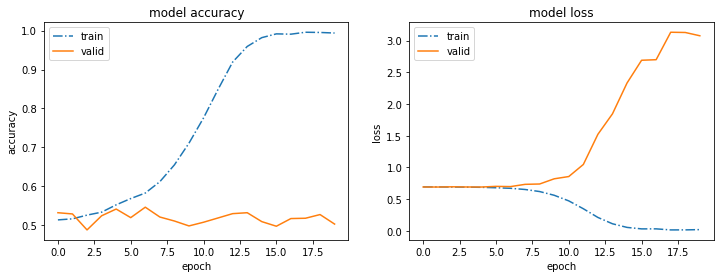

In [196]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_d6.history['accuracy'],linestyle='-.')
plt.plot(history_d6.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.subplot(1,2,(2))
plt.plot(history_d6.history['loss'],linestyle='-.')
plt.plot(history_d6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

In [197]:
# evaluate the model
_, train_acc_d6 = model_d6.evaluate(X_train, Y_train, verbose=0)
_, val_acc_d6   = model_d6.evaluate(X_val, Y_val, verbose=0)
_, test_acc_d6  = model_d6.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_d6, val_acc_d6, test_acc_d6))

Train: 0.9936, Val: 0.5028, Test: 0.5175


In [198]:
res_d6 = pd.DataFrame(
          {'ID': 'D6',
           'Type': '2D CNN',
           'Timesteps': 16,
           'Train Acc': train_acc_d6,
           'Val Acc': val_acc_d6,
           'Test Acc': test_acc_d6}, index=['D6: 2D CNN - linechart - 16 timesteps - 32x32 pixel - deeper'])

pd.concat([res_a1,res_a2,res_a3,res_a4,res_a5,res_a6,
           res_b1,res_b2,res_b3,
           res_c1,res_c2,res_c3,res_c4,
           res_d1,res_d2,res_d3,res_d4,res_d5,res_d6])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234
A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned,A3,1D CNN,8,0.73894900,0.50828731,0.51385587
A4: 1D CNN - scaled - without dilation - 16 timesteps - tuned v1,A4,1D CNN,16,0.92952186,0.49960536,0.51429707
A5: 1D CNN - scaled - without dilation - 16 timesteps - tuned v2,A5,1D CNN,16,0.98353630,0.51775849,0.48332009
A6: 1D CNN - scaled - with dilation - 16 timesteps - tuned,A6,1D CNN,16,0.96053225,0.49486977,0.51191419
B1: fcNN - scaled - 8 timesteps,B1,fcNN,8,0.65820926,0.49802685,0.50395882
B2: fcNN - scaled - 8 timesteps - with dropout,B2,fcNN,8,0.55615699,0.50276244,0.50118762
B3: fcNN - scaled - 16 timesteps,B3,fcNN,16,0.64253497,0.49171272,0.48610008
C1: LSTM - non-scaled - 8 timesteps - one LSTM layer,C1,LSTM,8,0.52210194,0.50828731,0.51781476


### D7) 2D CNN - linechart - 16 timesteps - 32x32 pixel - with dropout

In [0]:
# define hyperparameter of the CNN
batch_size = 128
nb_classes = 2
img_rows, img_cols = 32, 32
ks = (3, 3)
input_shape = (img_rows, img_cols, 1)
pool_size = (2, 2)

In [200]:
model_d7 = Sequential()

model_d7.add(Convolution2D(filters=8, kernel_size=ks, activation='relu', padding='same', input_shape=input_shape))
model_d7.add(Convolution2D(filters=8, kernel_size=ks, activation='relu', padding='same'))
model_d7.add(MaxPooling2D(pool_size=pool_size))

model_d7.add(Convolution2D(16, kernel_size=ks, activation='relu', padding='same'))
model_d7.add(Convolution2D(16, kernel_size=ks, activation='relu', padding='same'))
model_d7.add(MaxPooling2D(pool_size=pool_size))

model_d7.add(Flatten())
#model_d7.add(Dropout(0.3))
model_d7.add(Dense(200, activation='relu'))
model_d7.add(Dropout(0.2))
model_d7.add(Dense(100, activation='relu'))
model_d7.add(Dropout(0.2))
model_d7.add(Dense(50, activation='relu'))

model_d7.add(Dense(nb_classes))
model_d7.add(Activation('softmax'))

model_d7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_d7.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 8)         80        
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 16)        1168      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 1024)            

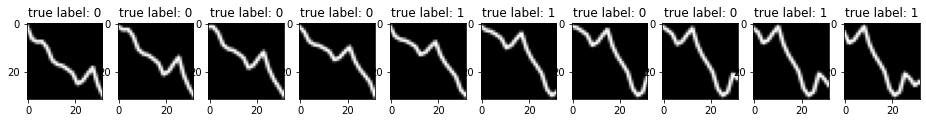

In [201]:
# quick check to see if we still have the correct X...
# visualize the 4 first linechart images 
plt.figure(figsize=(16,12))
for i in range(0,10):
    plt.subplot(1,10,(i+1))
    plt.imshow((X_train[i,:,:,0]),cmap="gray")
    plt.title('true label: '+np.str(np.argmax(Y_train,axis=1)[i]))
    #plt.axis('off')

In [202]:
# train the model
history_d7 = model_d7.fit(X_train, Y_train,
                          epochs=20,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/20
70/70 [==============================] - 1s 9ms/step - loss: 0.6931 - accuracy: 0.5105 - val_loss: 0.6907 - val_accuracy: 0.5351
Epoch 2/20
70/70 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.5145 - val_loss: 0.6916 - val_accuracy: 0.5406
Epoch 3/20
70/70 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.5136 - val_loss: 0.6921 - val_accuracy: 0.5170
Epoch 4/20
70/70 [==============================] - 0s 6ms/step - loss: 0.6914 - accuracy: 0.5205 - val_loss: 0.6931 - val_accuracy: 0.5075
Epoch 5/20
70/70 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5379 - val_loss: 0.6921 - val_accuracy: 0.5257
Epoch 6/20
70/70 [==============================] - 0s 6ms/step - loss: 0.6883 - accuracy: 0.5385 - val_loss: 0.6956 - val_accuracy: 0.5099
Epoch 7/20
70/70 [==============================] - 0s 6ms/step - loss: 0.6821 - accuracy: 0.5681 - val_loss: 0.6990 - val_accuracy: 0.5020
Epoch 8/20
70/70 [==

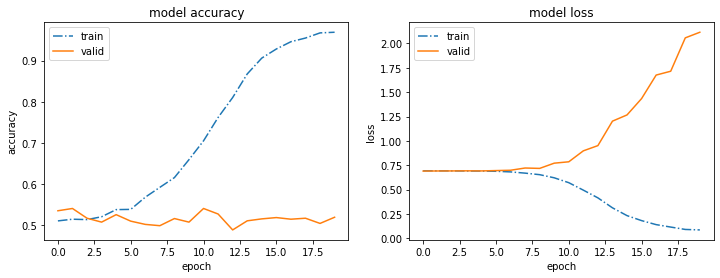

In [203]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_d7.history['accuracy'],linestyle='-.')
plt.plot(history_d7.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.subplot(1,2,(2))
plt.plot(history_d7.history['loss'],linestyle='-.')
plt.plot(history_d7.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

In [204]:
# evaluate the model
_, train_acc_d7 = model_d7.evaluate(X_train, Y_train, verbose=0)
_, val_acc_d7   = model_d7.evaluate(X_val, Y_val, verbose=0)
_, test_acc_d7  = model_d7.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_d7, val_acc_d7, test_acc_d7))

Train: 0.9948, Val: 0.5193, Test: 0.5115


In [205]:
res_d7 = pd.DataFrame(
          {'ID': 'D7',
           'Type': '2D CNN',
           'Timesteps': 16,
           'Train Acc': train_acc_d7,
           'Val Acc': val_acc_d7,
           'Test Acc': test_acc_d7}, index=['D7: 2D CNN - linechart - 16 timesteps - 32x32 pixel - with dropout'])

pd.concat([res_a1,res_a2,res_a3,res_a4,res_a5,res_a6,
           res_b1,res_b2,res_b3,
           res_c1,res_c2,res_c3,res_c4,
           res_d1,res_d2,res_d3,res_d4,res_d5,res_d6,res_d7])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234
A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned,A3,1D CNN,8,0.73894900,0.50828731,0.51385587
A4: 1D CNN - scaled - without dilation - 16 timesteps - tuned v1,A4,1D CNN,16,0.92952186,0.49960536,0.51429707
A5: 1D CNN - scaled - without dilation - 16 timesteps - tuned v2,A5,1D CNN,16,0.98353630,0.51775849,0.48332009
A6: 1D CNN - scaled - with dilation - 16 timesteps - tuned,A6,1D CNN,16,0.96053225,0.49486977,0.51191419
B1: fcNN - scaled - 8 timesteps,B1,fcNN,8,0.65820926,0.49802685,0.50395882
B2: fcNN - scaled - 8 timesteps - with dropout,B2,fcNN,8,0.55615699,0.50276244,0.50118762
B3: fcNN - scaled - 16 timesteps,B3,fcNN,16,0.64253497,0.49171272,0.48610008
C1: LSTM - non-scaled - 8 timesteps - one LSTM layer,C1,LSTM,8,0.52210194,0.50828731,0.51781476


### D8) 2D CNN - linechart - 12 timesteps - 72x72 pixel - with dropout

In [0]:
X_dji_12_72 = np.load('/content/X_dji_12_72x72.npy')
Y_dji_12_72 = np.load('/content/Y_dji_12_72x72.npy')

In [0]:
# normalize inputs from 0-255 to 0-1
X_dji_12_72 /= 255

# one-hot encode label
number_of_classes = 2
Y_dji_12_72 = to_categorical(Y_dji_12_72, number_of_classes)

In [208]:
# split into train, validation and test
X_train = X_dji_12_72[0:train_id]
Y_train = Y_dji_12_72[0:train_id]

X_val = X_dji_12_72[train_id:val_id]
Y_val = Y_dji_12_72[train_id:val_id]

X_test = X_dji_12_72[val_id:]
Y_test = Y_dji_12_72[val_id:]

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(8868, 72, 72, 1) (8868, 2)
(1267, 72, 72, 1) (1267, 2)
(2513, 72, 72, 1) (2513, 2)


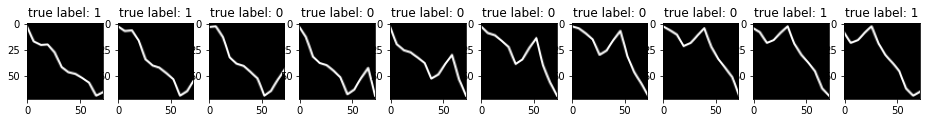

In [209]:
# visualize the 4 first linechart images 
plt.figure(figsize=(16,12))
for i in range(0,10):
    plt.subplot(1,10,(i+1))
    plt.imshow((X_train[i,:,:,0]),cmap="gray")
    plt.title('true label: '+np.str(np.argmax(Y_train,axis=1)[i]))
    #plt.axis('off')

In [0]:
# define hyperparameter of the CNN
batch_size = 128
nb_classes = 2
img_rows, img_cols = 72, 72
ks = (3, 3)
input_shape = (img_rows, img_cols, 1)
pool_size = (2, 2)

In [211]:
model_d8 = Sequential()

model_d8.add(Convolution2D(filters=16, kernel_size=ks, activation='relu', padding='same', input_shape=input_shape))
model_d8.add(Convolution2D(filters=16, kernel_size=ks, activation='relu', padding='same'))
model_d8.add(MaxPooling2D(pool_size=pool_size))

model_d8.add(Convolution2D(32, kernel_size=ks, activation='relu', padding='same'))
model_d8.add(Convolution2D(32, kernel_size=ks, activation='relu', padding='same'))
model_d8.add(MaxPooling2D(pool_size=pool_size))

model_d8.add(Flatten())
model_d8.add(Dropout(0.3))
model_d8.add(Dense(500, activation='relu'))
model_d8.add(Dropout(0.3))
model_d8.add(Dense(300, activation='relu'))
model_d8.add(Dropout(0.3))
model_d8.add(Dense(100, activation='relu'))

model_d8.add(Dense(nb_classes))
model_d8.add(Activation('softmax'))

model_d8.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_d8.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 72, 72, 16)        160       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 72, 72, 16)        2320      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 36, 36, 32)        4640      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 36, 36, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 18, 18, 32)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 10368)           

In [212]:
# train the model
history_d8 = model_d8.fit(X_train, Y_train,
                          epochs=20,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/20
70/70 [==============================] - 2s 33ms/step - loss: 0.6931 - accuracy: 0.5077 - val_loss: 0.6925 - val_accuracy: 0.5335
Epoch 2/20
70/70 [==============================] - 2s 26ms/step - loss: 0.6934 - accuracy: 0.5018 - val_loss: 0.6906 - val_accuracy: 0.5335
Epoch 3/20
70/70 [==============================] - 2s 26ms/step - loss: 0.6931 - accuracy: 0.5135 - val_loss: 0.6918 - val_accuracy: 0.5335
Epoch 4/20
70/70 [==============================] - 2s 26ms/step - loss: 0.6928 - accuracy: 0.5135 - val_loss: 0.6924 - val_accuracy: 0.5335
Epoch 5/20
70/70 [==============================] - 2s 26ms/step - loss: 0.6928 - accuracy: 0.5168 - val_loss: 0.6912 - val_accuracy: 0.5328
Epoch 6/20
70/70 [==============================] - 2s 26ms/step - loss: 0.6927 - accuracy: 0.5136 - val_loss: 0.6915 - val_accuracy: 0.5335
Epoch 7/20
70/70 [==============================] - 2s 26ms/step - loss: 0.6920 - accuracy: 0.5192 - val_loss: 0.6952 - val_accuracy: 0.4830
Epoch 8/20
70

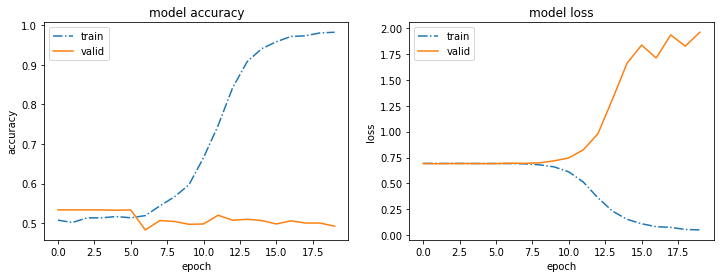

In [213]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_d8.history['accuracy'],linestyle='-.')
plt.plot(history_d8.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.subplot(1,2,(2))
plt.plot(history_d8.history['loss'],linestyle='-.')
plt.plot(history_d8.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

In [214]:
# evaluate the model
_, train_acc_d8 = model_d8.evaluate(X_train, Y_train, verbose=0)
_, val_acc_d8   = model_d8.evaluate(X_val, Y_val, verbose=0)
_, test_acc_d8  = model_d8.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_d8, val_acc_d8, test_acc_d8))

Train: 1.0000, Val: 0.4925, Test: 0.4883


In [215]:
res_d8 = pd.DataFrame(
          {'ID': 'D8',
           'Type': '2D CNN',
           'Timesteps': 12,
           'Train Acc': train_acc_d8,
           'Val Acc': val_acc_d8,
           'Test Acc': test_acc_d8}, index=['D8: 2D CNN - linechart - 12 timesteps - 72x72 pixel - with dropout'])

pd.concat([res_a1,res_a2,res_a3,res_a4,res_a5,res_a6,
           res_b1,res_b2,res_b3,
           res_c1,res_c2,res_c3,res_c4,
           res_d1,res_d2,res_d3,res_d4,res_d5,res_d6,res_d7,res_d8])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234
A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned,A3,1D CNN,8,0.73894900,0.50828731,0.51385587
A4: 1D CNN - scaled - without dilation - 16 timesteps - tuned v1,A4,1D CNN,16,0.92952186,0.49960536,0.51429707
A5: 1D CNN - scaled - without dilation - 16 timesteps - tuned v2,A5,1D CNN,16,0.98353630,0.51775849,0.48332009
A6: 1D CNN - scaled - with dilation - 16 timesteps - tuned,A6,1D CNN,16,0.96053225,0.49486977,0.51191419
B1: fcNN - scaled - 8 timesteps,B1,fcNN,8,0.65820926,0.49802685,0.50395882
B2: fcNN - scaled - 8 timesteps - with dropout,B2,fcNN,8,0.55615699,0.50276244,0.50118762
B3: fcNN - scaled - 16 timesteps,B3,fcNN,16,0.64253497,0.49171272,0.48610008
C1: LSTM - non-scaled - 8 timesteps - one LSTM layer,C1,LSTM,8,0.52210194,0.50828731,0.51781476


### D9) 2D CNN - linechart - 40 timesteps - 72x72 pixel

In [0]:
X_dji_40_72 = np.load('/content/X_dji_40_72x72.npy')
Y_dji_40_72 = np.load('/content/Y_dji_40_72x72.npy')

In [0]:
# normalize inputs from 0-255 to 0-1
X_dji_40_72 /= 255

# one-hot encode label
number_of_classes = 2
Y_dji_40_72 = to_categorical(Y_dji_40_72, number_of_classes)

In [218]:
# split into train, validation and test
X_train = X_dji_40_72[0:train_id]
Y_train = Y_dji_40_72[0:train_id]

X_val = X_dji_40_72[train_id:val_id]
Y_val = Y_dji_40_72[train_id:val_id]

X_test = X_dji_40_72[val_id:]
Y_test = Y_dji_40_72[val_id:]

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(8868, 72, 72, 1) (8868, 2)
(1267, 72, 72, 1) (1267, 2)
(2485, 72, 72, 1) (2485, 2)


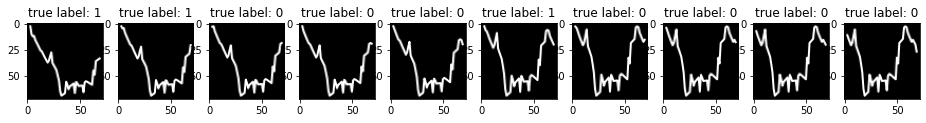

In [219]:
# visualize the 4 first linechart images 
plt.figure(figsize=(16,12))
for i in range(0,10):
    plt.subplot(1,10,(i+1))
    plt.imshow((X_train[i,:,:,0]),cmap="gray")
    plt.title('true label: '+np.str(np.argmax(Y_train,axis=1)[i]))
    #plt.axis('off')

In [0]:
# define hyperparameter of the CNN
batch_size = 128
nb_classes = 2
img_rows, img_cols = 72, 72
ks = (3, 3)
input_shape = (img_rows, img_cols, 1)
pool_size = (2, 2)

In [221]:
model_d9 = Sequential()

model_d9.add(Convolution2D(filters=16, kernel_size=ks, activation='relu', padding='same', input_shape=input_shape))
model_d9.add(Convolution2D(filters=16, kernel_size=ks, activation='relu', padding='same'))
model_d9.add(MaxPooling2D(pool_size=pool_size))

model_d9.add(Convolution2D(32, kernel_size=ks, activation='relu', padding='same'))
model_d9.add(Convolution2D(32, kernel_size=ks, activation='relu', padding='same'))
model_d9.add(MaxPooling2D(pool_size=pool_size))

model_d9.add(Flatten())
model_d9.add(Dense(128, activation='relu'))
model_d9.add(Dense(nb_classes))
model_d9.add(Activation('softmax'))

# compile model and intitialize weights
model_d9.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# summarize model along with number of model weights
model_d9.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 72, 72, 16)        160       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 72, 72, 16)        2320      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 36, 36, 32)        4640      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 36, 36, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 18, 18, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 10368)           

In [222]:
history_d9 = model_d9.fit(X_train, Y_train,
                          epochs=20,
                          batch_size=128,
                          validation_data=(X_val, Y_val),
                          verbose=1)

Epoch 1/20
70/70 [==============================] - 2s 26ms/step - loss: 0.6936 - accuracy: 0.5156 - val_loss: 0.6928 - val_accuracy: 0.5422
Epoch 2/20
70/70 [==============================] - 2s 24ms/step - loss: 0.6925 - accuracy: 0.5167 - val_loss: 0.6908 - val_accuracy: 0.5399
Epoch 3/20
70/70 [==============================] - 2s 24ms/step - loss: 0.6898 - accuracy: 0.5309 - val_loss: 0.6927 - val_accuracy: 0.5209
Epoch 4/20
70/70 [==============================] - 2s 24ms/step - loss: 0.6813 - accuracy: 0.5608 - val_loss: 0.6943 - val_accuracy: 0.5296
Epoch 5/20
70/70 [==============================] - 2s 24ms/step - loss: 0.6607 - accuracy: 0.6088 - val_loss: 0.7074 - val_accuracy: 0.5241
Epoch 6/20
70/70 [==============================] - 2s 24ms/step - loss: 0.6018 - accuracy: 0.6746 - val_loss: 0.7780 - val_accuracy: 0.5099
Epoch 7/20
70/70 [==============================] - 2s 24ms/step - loss: 0.4761 - accuracy: 0.7793 - val_loss: 0.9149 - val_accuracy: 0.5312
Epoch 8/20
70

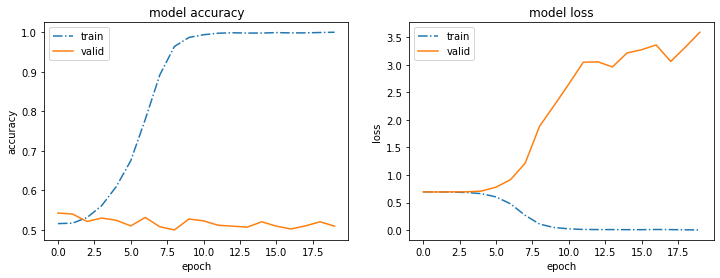

In [223]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_d9.history['accuracy'],linestyle='-.')
plt.plot(history_d9.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.subplot(1,2,(2))
plt.plot(history_d9.history['loss'],linestyle='-.')
plt.plot(history_d9.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

In [224]:
# evaluate the model
_, train_acc_d9 = model_d9.evaluate(X_train, Y_train, verbose=0)
_, val_acc_d9   = model_d9.evaluate(X_val, Y_val, verbose=0)
_, test_acc_d9  = model_d9.evaluate(X_test, Y_test, verbose=0)
print('Train: %.4f, Val: %.4f, Test: %.4f' % (train_acc_d9, val_acc_d9, test_acc_d9))

Train: 0.9999, Val: 0.5091, Test: 0.4994


In [225]:
res_d9 = pd.DataFrame(
          {'ID': 'D9',
           'Type': '2D CNN',
           'Timesteps': 40,
           'Train Acc': train_acc_d9,
           'Val Acc': val_acc_d9,
           'Test Acc': test_acc_d9}, index=['D9: 2D CNN - linechart - 40 timesteps - 72x72 pixel'])

pd.concat([res_a1,res_a2,res_a3,res_a4,res_a5,res_a6,
           res_b1,res_b2,res_b3,
           res_c1,res_c2,res_c3,res_c4,
           res_d1,res_d2,res_d3,res_d4,res_d5,res_d6,res_d7,res_d8,res_d9])

,ID,Type,Timesteps,Train Acc,Val Acc,Test Acc
A1: 1D CNN - non-scaled - without dilation - 8 timesteps,A1,1D CNN,8,0.54409111,0.49802685,0.49524942
A2: 1D CNN - scaled - without dilation - 8 timesteps,A2,1D CNN,8,0.53845286,0.50039464,0.50554234
A3: 1D CNN - scaled - without dilation - 8 timesteps - tuned,A3,1D CNN,8,0.73894900,0.50828731,0.51385587
A4: 1D CNN - scaled - without dilation - 16 timesteps - tuned v1,A4,1D CNN,16,0.92952186,0.49960536,0.51429707
A5: 1D CNN - scaled - without dilation - 16 timesteps - tuned v2,A5,1D CNN,16,0.98353630,0.51775849,0.48332009
A6: 1D CNN - scaled - with dilation - 16 timesteps - tuned,A6,1D CNN,16,0.96053225,0.49486977,0.51191419
B1: fcNN - scaled - 8 timesteps,B1,fcNN,8,0.65820926,0.49802685,0.50395882
B2: fcNN - scaled - 8 timesteps - with dropout,B2,fcNN,8,0.55615699,0.50276244,0.50118762
B3: fcNN - scaled - 16 timesteps,B3,fcNN,16,0.64253497,0.49171272,0.48610008
C1: LSTM - non-scaled - 8 timesteps - one LSTM layer,C1,LSTM,8,0.52210194,0.50828731,0.51781476
